In [150]:
import pandas as pd
import numpy as np
from os import listdir
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import *
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats.mstats import winsorize
import statsmodels.stats.api as sms
from statsmodels.compat import lzip

In [7]:
def prepare_datasets(filepath):
    data = pd.read_excel(filepath, skiprows = [0,1,2,3,4,5,6,7,8,9,10,11,12])
    data_split = np.split(data, data[data.isnull().all(1)].index) 
    data_income = data_split[0]
    data_balance = data_split[2]
    data_flow = data_split[4]
    
    data_income.dropna(axis=0, how = "all", inplace = True)
    data_balance.dropna(axis=0, how = "all", inplace = True)
    data_flow.dropna(axis=0, how = "all", inplace = True)
    
    data_income.columns = data_income.iloc[0]
    data_income = data_income[1:]
    data_balance.columns = data_balance.iloc[0]
    data_balance = data_balance[1:]
    data_flow.columns = data_flow.iloc[0]
    data_flow = data_flow[1:]
    
    return data_income, data_balance, data_flow 

In [248]:
def data_cleaning(data_income, data_balance, data_flow):
    index = ["Zobowiązania handlowe i inne", "Aktywa ogółem", "Aktywa obrotowe", "Zapasy", "Gotówka i ekwiwalenty","Kapitał własny ogółem", "Należności handlowe i inne", "Długoterminowe kredyty i pożyczki", "Pożyczki krótkoterminowe", "Zysk netto (strata netto)", "Przychody netto ze sprzedaży", "Przepływy środków pieniężnych z działalności operacyjnej", "Zobowiązania krótkoterminowe", "Zobowiązania ogółem"]
    
    data_income['Rachunek zysków i strat'] = data_income['Rachunek zysków i strat'].str.strip()
    data_balance['Bilans'] = data_balance['Bilans'].str.strip()
    data_flow['Rachunek przepływów pieniężnych'] = data_flow['Rachunek przepływów pieniężnych'].str.strip()
    
    data_income = data_income[data_income['Rachunek zysków i strat'].isin(index)]
    data_balance = data_balance[data_balance['Bilans'].isin(index)]
    data_flow = data_flow[data_flow['Rachunek przepływów pieniężnych'].isin(index)]
    
    data_income = data_income.reset_index(drop=True)
    data_balance = data_balance.reset_index(drop=True)
    data_flow = data_flow.reset_index(drop=True)
    
    data_income.rename(columns = {'Rachunek zysków i strat':"Bilans"}, inplace = True) 
    data_flow.rename(columns = {'Rachunek przepływów pieniężnych':"Bilans"}, inplace = True)
    
    return data_income, data_balance, data_flow

In [9]:
def data_connected(data_income, data_balance, data_flow, i):
    data_connected = [data_income, data_balance, data_flow]
    result = pd.concat(data_connected, ignore_index = True)
    result = result.transpose()
    result.columns = result.iloc[0]
    result = result[1:]
    result = result.reset_index()
    count = result.shape[0]
    company_id = [i]*count
    result = result.assign(company_id=company_id)
    result = result.set_index('company_id')
    return result

In [10]:
def add_sector(df, folder):
    count = df.shape[0]
    sector = [folder]*count
    df = df.assign(sector=sector)
    return df

In [314]:
def transform_to_square(df):
    df['Dźwignia_2'] = df['Dźwignia']*df['Dźwignia']
    df['Płynność_2'] = df['Płynność']*df['Płynność']
    df['Rentowność_2'] = df['Rentowność']*df['Rentowność']
    df['Longterm_bank_2'] = df['Longterm_bank']*df['Longterm_bank']
    #df['Rozmiar_2'] = df['Rozmiar']*df['Rozmiar']
    df['Shortterm_bank_2'] = df['Shortterm_bank']*df['Shortterm_bank']
    return df

In [241]:
macro_df = pd.read_excel('GDPCPI.xlsx')
macro_df

,Rok,GDP Growth,CPI
0,2014,3.8,0.0
1,2015,4.4,-0.9
2,2016,3.0,-0.6
3,2017,5.1,2.0
4,2018,5.9,1.6
5,2019,4.4,2.3
6,2020,-2.0,3.4
7,2021,6.9,5.1
8,2022,5.1,14.4


In [242]:
master_df = pd.merge(df,macro_df, on='Rok', how='outer')

In [243]:
master_df

,company_id,Rok,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,Zobowiązania krótkoterminowe,Pożyczki krótkoterminowe,Zobowiązania handlowe i inne,Przepływy środków pieniężnych z działalności operacyjnej,sector,dependent,GDP Growth,CPI
0,1,2022,2451715,175636,4818709,938181,195860,475059,1111045,20100,449157,8278,49855,624375,1,0.010346,5.1,14.4
1,2,2022,6790515,113573,3985674,2074617,1034891,164414,2296613,403187,1687747,940322,830897,286107,1,0.208471,5.1,14.4
2,3,2022,3666690,610373,2083016,1342661,549078,335761,854585,244536,508473,70487,432930,486418,1,0.207838,5.1,14.4
3,4,2022,5415459,564701,8092527,3191785,771541,684969,5388217,1776129,3206787,224315,2796067,842301,1,0.345512,5.1,14.4
4,6,2022,20198500,7593800,26963100,7852300,990100,4837900,11025600,1096400,7733700,779400,3146700,10689800,1,0.116704,5.1,14.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,314,2014,561.03,-55.07,87.19,81.26,2.29,47.73,233.59,0,233.43,140,77.83,,7,0.892648,3.8,0.0
2294,315,2014,17544,8434,14777,13114,0,3612,4821,0,4821,3931,0,4381,7,0.0,3.8,0.0
2295,316,2014,601,-2957,3903,3163,0,2326,560,65,484,273,0,-2717,7,0.0,3.8,0.0
2296,317,2014,8027.38,1098.72,13082.56,10190.93,0,54.25,11466.9,0,11409.77,0,1723.57,,7,0.131746,3.8,0.0


In [2]:
files = listdir("Dane")

In [3]:
files

['Chemia_surowce',
 'Dobra_konsumpcyjne',
 'Handel_uslugi',
 'Ochrona_zdrowia',
 'Paliwa_energia',
 'Produkcja_przemysłowa_budowlano_montazowa',
 'Technologie']

In [323]:
def variable(df):
    df['dependent'] = df['Zobowiązania handlowe i inne']/df['Aktywa ogółem']
    df['Gotówka_płynność'] = df['Gotówka i ekwiwalenty']/df['Aktywa ogółem']
    df['Rentowność'] = df['Zysk netto (strata netto)']/df['Aktywa ogółem']
    df['Płynność'] = (df['Aktywa obrotowe'] - df['Zapasy'])/df['Zobowiązania krótkoterminowe']
    df['Dźwignia'] = df['Zobowiązania ogółem']/df['Aktywa ogółem']
    df['Shortterm_bank'] = df['Pożyczki krótkoterminowe']/df['Aktywa ogółem']
    df['Longterm_bank'] = df['Długoterminowe kredyty i pożyczki']/df['Aktywa ogółem']
    df['Cashflow'] = df['Przepływy środków pieniężnych z działalności operacyjnej']/df['Aktywa ogółem']
    df['Rozmiar'] = np.log(df['Aktywa ogółem'])
    df['Naleznosci_handlowe'] = df['Należności handlowe i inne']/df['Aktywa ogółem']
    df['Zapasy_1'] = df['Zapasy']/df['Aktywa ogółem']
    df['ROE'] = df['Zysk netto (strata netto)']/df['Kapitał własny ogółem']
    df['ROS'] = df['Zysk netto (strata netto)']/df['Przychody netto ze sprzedaży']
    return df
    


In [358]:
def main(drop=True):
    sector_map = {'Chemia_surowce':1,'Dobra_konsumpcyjne':2,
 'Handel_uslugi':3,
 'Ochrona_zdrowia':4,
 'Paliwa_energia':5,
 'Produkcja_przemysłowa_budowlano_montazowa':6,
 'Technologie':7 }
    main_catalog = "Dane"
    folders = listdir(main_catalog)
    i = 1
    j = 0
    for folder in folders:
        path = f"{main_catalog}/{folder}"
        files = listdir(path)
        for file in files:
            filepath = f"{path}/{file}"
            
            data_income, data_balance, data_flow = prepare_datasets(filepath)
            data_income, data_balance, data_flow = data_cleaning(data_income, data_balance, data_flow)
            result = data_connected(data_income, data_balance, data_flow, i)
            result = add_sector(result, folder)
            #year = [2000, 2001, 2002, 2003, 2004, 2005, 2023]
            #result = result[result.Rok.isin(year) == False]
            #result = result.loc[result["index"] != [2000, 2001, 2002, 2003, 2004, 2005, 2023] ]

            #if result.shape[0] != 8:
                #print(f"W folderze {folder} w pliku {file}")
                #j += 1
            #if drop:
                #if drop:
                    #continue
            if i == 1:
                master_df = result
            else:
                list_df = [master_df, result]
                master_df = pd.concat(list_df)
        
            i += 1
    print(f'Liczba plików = {j}') 
    
    master_df["sector"] = master_df["sector"].map(sector_map)
    master_df = master_df.fillna(0)
    master_df = master_df.reset_index()
    #master_df = master_df.dropna().reset_index()
    master_df['index'] = master_df['index'].astype(int)
    cols = master_df.columns.drop(['company_id','index','sector'])
    # cols = df.columns.drop('company_id')
    master_df[cols] = master_df[cols].apply(pd.to_numeric, errors='coerce')
    master_df = master_df.rename(columns ={'index': 'Rok'})
    master_df = master_df.drop(master_df.loc[master_df['Zobowiązania krótkoterminowe']==0].index)
    master_df = master_df.drop(master_df.loc[master_df['Aktywa ogółem']==0].index)
    master_df = master_df.drop(master_df.loc[master_df['Przychody netto ze sprzedaży']== 0 ].index)
    year = [2000, 2001, 2002, 2003, 2004, 2005,2006, 2007, 2008, 2009, 2023]
    master_df = master_df[master_df.Rok.isin(year) == False]
    #master_df = variable(master_df)
    #macro_df = pd.read_excel('GDPCPI.xlsx')
    #macro_df = macro_df.rename(columns = {'GDP Growth':'GDP_Growth'})
    #master_df = pd.merge(master_df, macro_df, on = 'Rok', how = 'outer')
    #master_df = wins(master_df)
    #master_df = transform_to_square(master_df)
    
    return master_df

In [359]:
df = main()

Liczba plików = 0


In [371]:
def ready_dataframe(df):
    for i in range(df['company_id'].max()):
        id = i+1
        tmp_df = df[df['company_id'] == id]
        tmp_df = tmp_df.tail(-1)
        tmp_df_2 = tmp_df.iloc[:-2]
        print(tmp_df)
        print(tmp_df_2)
        
        if id > 3:
            break

In [372]:
ready_dataframe(df)


Bilans  company_id   Rok  Przychody netto ze sprzedaży  \
1                1  2021                     2371280.0   
2                1  2020                     1822112.0   
3                1  2019                     2157861.0   
4                1  2018                     1756671.0   
5                1  2017                     1780321.0   
6                1  2016                     1786265.0   
7                1  2015                     1885371.0   
8                1  2014                     2013568.0   
9                1  2013                     1899830.0   
10               1  2012                     1835801.0   
11               1  2011                     1301349.0   
12               1  2010                     1221540.0   

Bilans  Zysk netto (strata netto)  Aktywa ogółem  Aktywa obrotowe    Zapasy  \
1                        288266.0      4702044.0        1025616.0   99744.0   
2                         72962.0      4375263.0         611318.0   91124.0   
3       

In [361]:
df.tail(60)

Bilans,company_id,Rok,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Należności handlowe i inne,Gotówka i ekwiwalenty,Kapitał własny ogółem,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,Zobowiązania krótkoterminowe,Pożyczki krótkoterminowe,Zobowiązania handlowe i inne,Przepływy środków pieniężnych z działalności operacyjnej,sector
4391,318,2021,33355.52,474.95,45983.31,24396.55,4616.08,7607.19,11859.98,18200.51,26990.06,531.53,12612.78,4765.56,5114.17,-11323.35,7
4392,318,2020,28966.31,1775.56,30790.74,23077.51,950.37,6149.16,6363.09,7195.44,23595.30,0.00,21303.83,3217.61,9936.93,-4557.92,7
4393,318,2019,25486.13,255.36,21430.55,15529.50,1811.86,5139.08,2894.60,5419.88,16010.67,0.00,14939.14,1577.50,9358.32,-6467.84,7
4394,318,2018,27116.51,-3285.13,23313.88,15627.47,1385.56,6982.84,2528.61,5164.52,18149.36,0.00,16583.10,1996.27,13050.13,-3152.30,7
4395,318,2017,11886.98,29.96,21768.36,12832.18,338.64,7396.48,1652.95,8449.65,13318.72,0.00,12032.82,500.00,8949.70,-1578.47,7
4396,318,2016,8568.01,281.10,13812.76,7225.27,178.74,1215.43,1900.55,8375.93,5436.84,0.00,3844.29,9.05,1512.23,-487.84,7
4397,318,2015,3843.02,-579.21,10526.51,7445.30,373.13,1982.13,2164.06,8094.82,2431.69,0.00,1374.71,167.44,591.87,NaN,7
4398,318,2014,2909.41,108.91,6025.68,3420.34,247.99,1392.36,1030.15,3683.23,2342.45,0.00,1225.91,275.66,415.88,-980.20,7
4399,318,2013,1271.39,50.86,1643.14,762.89,64.21,411.46,101.83,565.31,1077.83,0.00,532.11,250.00,247.60,-307.78,7
4400,318,2012,594.81,-177.29,1438.15,436.05,47.85,144.27,239.98,507.72,930.43,0.00,250.42,0.00,226.22,NaN,7


In [237]:
df.to_excel('C:/Users/misiak/OneDrive - Hewlett Packard Enterprise/Desktop/Dataframe.xlsx', sheet_name = 'Raw_data')

In [337]:
df.to_excel('C:/Users/misiak/OneDrive - Hewlett Packard Enterprise/Desktop/Dataframe_v1.xlsx')

In [335]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 4452
Data columns (total 35 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3585 non-null   int64  
 1   Rok                                                       3585 non-null   int32  
 2   Przychody netto ze sprzedaży                              3584 non-null   float64
 3   Zysk netto (strata netto)                                 3585 non-null   float64
 4   Aktywa ogółem                                             3585 non-null   float64
 5   Aktywa obrotowe                                           3585 non-null   float64
 6   Zapasy                                                    3573 non-null   float64
 7   Należności handlowe i inne                                3585 non-null   float64
 8   Gotówka i ekwiwale

In [352]:
df1 = df.drop(columns = ['Zobowiązania handlowe i inne', 'dependent'])

In [353]:
df1 = df1.drop(df1.iloc[:, 16:32], axis = 1)

In [354]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 4452
Data columns (total 17 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3585 non-null   int64  
 1   Rok                                                       3585 non-null   int32  
 2   Przychody netto ze sprzedaży                              3584 non-null   float64
 3   Zysk netto (strata netto)                                 3585 non-null   float64
 4   Aktywa ogółem                                             3585 non-null   float64
 5   Aktywa obrotowe                                           3585 non-null   float64
 6   Zapasy                                                    3573 non-null   float64
 7   Należności handlowe i inne                                3585 non-null   float64
 8   Gotówka i ekwiwale

In [160]:
df.describe()

,company_id,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,Zobowiązania krótkoterminowe,...,sector_5,sector_7,Rok_2015,Rok_2016,Rok_2017,Rok_2018,Rok_2019,Rok_2020,Rok_2021,Rok_2022
count,2297.000000,2.297000e+03,2.297000e+03,2.297000e+03,2.297000e+03,2.297000e+03,2.297000e+03,2.297000e+03,2.297000e+03,2.297000e+03,...,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000
mean,162.423161,2.098844e+06,8.226530e+04,2.459579e+06,7.948266e+05,2.303852e+05,1.721224e+05,1.257743e+06,3.962313e+05,6.586493e+05,...,0.060078,0.110144,0.108402,0.107967,0.117109,0.124075,0.123640,0.119721,0.118851,0.073139
std,95.386233,9.560447e+06,9.522225e+05,1.059945e+07,3.559732e+06,1.313725e+06,8.360038e+05,5.316644e+06,1.728476e+06,2.921624e+06,...,0.237684,0.313137,0.310955,0.310406,0.321620,0.329739,0.329242,0.324706,0.323683,0.260421
min,1.000000,-5.200250e+04,-8.514744e+06,1.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00,8.520000e+00,0.000000e+00,8.520000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,78.000000,7.787700e+04,1.415900e+02,9.092500e+04,4.087000e+04,2.936000e+03,3.699000e+03,3.369400e+04,9.640000e+02,2.111255e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,167.000000,2.361330e+05,8.357000e+03,2.494270e+05,1.157100e+05,2.480800e+04,1.502800e+04,1.174890e+05,1.318300e+04,8.240900e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,245.000000,9.525760e+05,3.600000e+04,8.721440e+05,3.883100e+05,1.040100e+05,6.210200e+04,4.495640e+05,7.813800e+04,2.897340e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,325.000000,2.785090e+08,3.545800e+07,2.727470e+08,1.178390e+08,4.477900e+07,2.140300e+07,1.338880e+08,2.635673e+07,9.207100e+07,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [262]:
df['Zobowiązania krótkoterminowe'].value_counts()[0]

1

In [326]:
df = pd.get_dummies(df, columns = ['sector'])
df = df.drop(columns = 'sector_6')

In [327]:
df = pd.get_dummies(df, columns = ['Rok'], drop_first = True)

In [64]:
df

,company_id,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,Zobowiązania krótkoterminowe,...,sector_5,sector_7,Rok_2015,Rok_2016,Rok_2017,Rok_2018,Rok_2019,Rok_2020,Rok_2021,Rok_2022
0,1,2451715.00,175636.00,4818709.00,938181.00,195860.00,475059.00,1111045.00,20100.00,449157.00,...,0,0,0,0,0,0,0,0,0,1
1,1,2371280.00,288266.00,4702044.00,1025616.00,99744.00,600175.00,1108335.00,25444.00,515524.00,...,0,0,0,0,0,0,0,0,1,0
2,1,1822112.00,72962.00,4375263.00,611318.00,91124.00,241610.00,1075436.00,30772.00,360386.00,...,0,0,0,0,0,0,0,1,0,0
3,1,2157861.00,308746.00,4252464.00,742684.00,104248.00,382740.00,1023962.00,28360.00,374162.00,...,0,0,0,0,0,0,1,0,0,0
4,1,1756671.00,53794.00,3933351.00,469529.00,83382.00,170793.00,983235.00,13930.00,446803.00,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,325,5777.66,-9672.55,50409.41,4036.45,8.80,1765.12,21753.70,5643.11,15084.97,...,0,1,0,0,0,0,0,0,0,1
2294,325,2492.71,-11883.86,51322.46,6585.32,8.12,5119.66,14758.10,0.00,13475.14,...,0,1,0,0,0,0,0,0,1,0
2295,325,1449.99,-10169.41,54643.38,11376.68,18.79,10594.93,21336.44,8223.38,11575.87,...,0,1,0,0,0,0,0,1,0,0
2296,325,679.67,-14998.81,47049.71,6216.83,34.18,4921.82,17985.91,0.00,16147.82,...,0,1,0,0,0,0,1,0,0,0


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 4452
Data columns (total 49 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3585 non-null   int64  
 1   Przychody netto ze sprzedaży                              3584 non-null   float64
 2   Zysk netto (strata netto)                                 3585 non-null   float64
 3   Aktywa ogółem                                             3585 non-null   float64
 4   Aktywa obrotowe                                           3585 non-null   float64
 5   Zapasy                                                    3573 non-null   float64
 6   Należności handlowe i inne                                3585 non-null   float64
 7   Gotówka i ekwiwalenty                                     3571 non-null   float64
 8   Kapitał własny ogó

In [215]:
df.head(40)

Bilans,company_id,Rok,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,...,Płynność,Dźwignia,Shortterm_bank,Longterm_bank,Cashflow,Rozmiar,Dźwignia_2,Płynność_2,Rentowność_2,Longterm_bank_2
0,1,2022,2451715.00,175636.00,4818709.00,938181.00,195860.00,475059.00,1111045.00,20100.0,...,1.652698,0.230569,0.001718,0.004171,0.129573,15.388017,0.053162,2.731412,0.001329,0.000017
1,1,2021,2371280.00,288266.00,4702044.00,1025616.00,99744.00,600175.00,1108335.00,25444.0,...,1.795982,0.235713,0.002106,0.005411,0.162230,15.363508,0.055561,3.225553,0.003758,0.000029
2,1,2020,1822112.00,72962.00,4375263.00,611318.00,91124.00,241610.00,1075436.00,30772.0,...,1.443436,0.245799,0.001407,0.007033,0.109013,15.291477,0.060417,2.083506,0.000278,0.000049
3,1,2019,2157861.00,308746.00,4252464.00,742684.00,104248.00,382740.00,1023962.00,28360.0,...,1.706309,0.240793,0.001002,0.006669,0.169543,15.263009,0.057981,2.911491,0.005271,0.000044
4,1,2018,1756671.00,53794.00,3933351.00,469529.00,83382.00,170793.00,983235.00,13930.0,...,0.864244,0.249974,0.000817,0.003542,0.116662,15.185002,0.062487,0.746918,0.000187,0.000013
5,1,2017,1780321.00,667925.00,4158872.00,730067.00,62557.00,434928.00,1257345.00,16966.0,...,0.896095,0.302328,0.073374,0.004079,0.146318,15.240754,0.091402,0.802986,0.025793,0.000017
6,1,2016,1786265.00,181992.00,3800289.00,870501.00,71571.00,541106.00,1507882.00,320002.0,...,1.068360,0.396781,0.079824,0.084205,0.177826,15.150588,0.157435,1.141392,0.002293,0.007090
7,1,2015,1885371.00,-279626.00,3644024.00,640951.00,103063.00,262037.00,1521402.00,718267.0,...,1.331017,0.417506,0.000858,0.197108,0.200211,15.108599,0.174311,1.771607,0.005888,0.038852
8,1,2014,2013568.00,272352.00,4364415.00,634250.00,132488.00,195481.00,1840588.00,713222.0,...,0.749674,0.421726,0.023057,0.163418,0.163335,15.288995,0.177853,0.562011,0.003894,0.026705
9,1,2013,1899830.00,329728.00,3844130.00,570126.00,111503.00,212004.00,1388599.00,200000.0,...,0.566924,0.361226,0.109518,0.052027,0.188871,15.162058,0.130484,0.321402,0.007357,0.002707


In [266]:
cols = df.columns.drop(['company_id','Rok','sector'])
# cols = df.columns.drop('company_id')
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')
df.dtypes

company_id                                                    int64
Rok                                                           int32
Przychody netto ze sprzedaży                                float64
Zysk netto (strata netto)                                   float64
Aktywa ogółem                                               float64
Aktywa obrotowe                                             float64
Zapasy                                                      float64
Gotówka i ekwiwalenty                                       float64
Zobowiązania ogółem                                         float64
Długoterminowe kredyty i pożyczki                           float64
Zobowiązania krótkoterminowe                                float64
Pożyczki krótkoterminowe                                    float64
Zobowiązania handlowe i inne                                float64
Przepływy środków pieniężnych z działalności operacyjnej    float64
sector                                          

In [338]:
descriptive = df.groupby(["Rok"])['dependent'].describe(include ='object')
descriptive

,count,mean,std,min,25%,50%,75%,max
Rok,,,,,,,,
2010,222.0,0.303793,0.324518,0.0,0.098671,0.205714,0.370444,1.273113
2011,252.0,0.234414,0.278787,0.0,0.074563,0.169127,0.269454,1.273113
2012,258.0,0.174423,0.137445,0.0,0.072482,0.137064,0.227734,0.687618
2013,263.0,0.156158,0.140781,0.0,0.065082,0.122842,0.197099,1.247582
2014,267.0,0.145282,0.127719,0.0,0.055309,0.117778,0.188490,0.892648
2015,266.0,0.148413,0.138964,0.0,0.060001,0.121203,0.191623,1.176570
2016,264.0,0.152361,0.139194,0.0,0.058672,0.121899,0.200746,1.273113
2017,288.0,0.163470,0.150977,0.0,0.062700,0.133749,0.209236,1.273113
2018,309.0,0.158496,0.148664,0.0,0.052728,0.128266,0.213666,1.273113


C:\Users\misiak\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


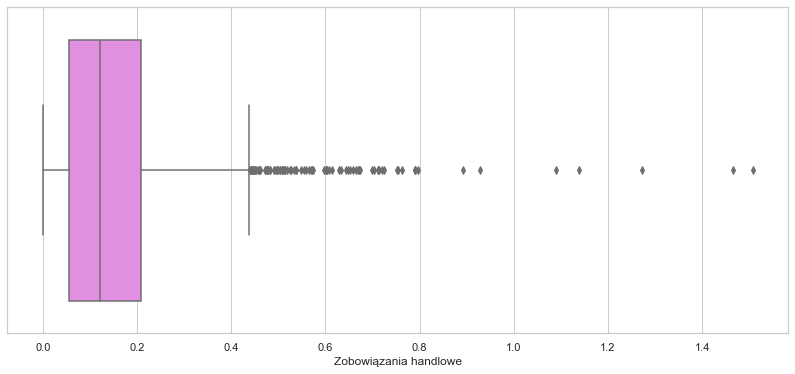

In [336]:
%matplotlib inline

sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(x='dependent', data=df, orient="v", color = 'violet')
plt.xlabel('Zobowiązania handlowe')
plt.savefig('boxplot.png')
plt.show()

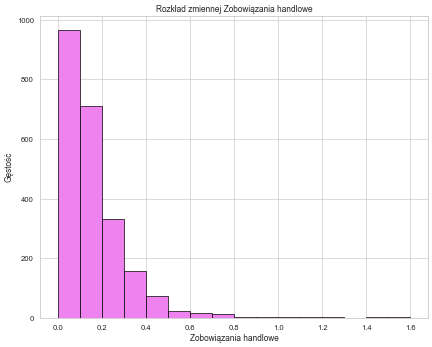

In [278]:
plt.figure(figsize = (10,8), dpi = 50)
plt.hist(x = df["dependent"], color = 'violet', range = (0,1.6), bins = 16, edgecolor = 'black' )
plt.xlabel('Zobowiązania handlowe')
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Zobowiązania handlowe')
plt.savefig('Rozlad_dependent.png')
plt.show()

In [273]:
df.groupby(["sector"])["dependent"].describe()[['count','mean']]

,count,mean
sector,,
1,352.0,0.148713
2,539.0,0.178927
3,597.0,0.166525
4,300.0,0.128338
5,195.0,0.096125
6,1167.0,0.166925
7,453.0,0.144098


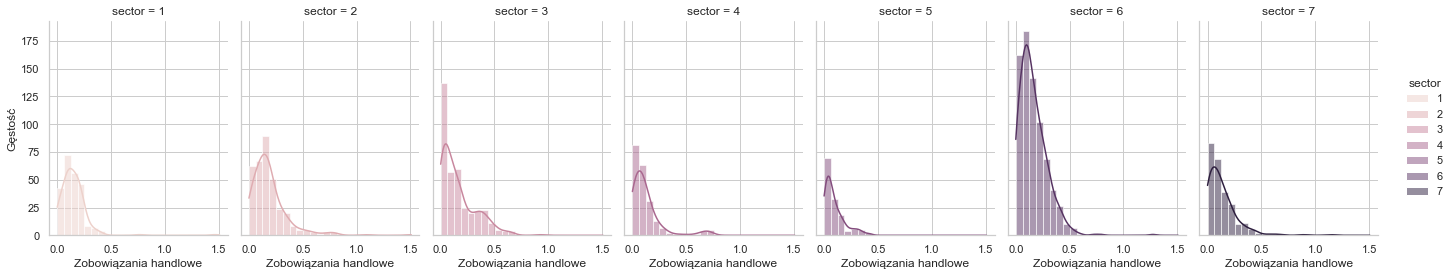

In [334]:
ax = sns.displot(
  data=df,
  x="dependent",
  col="sector",
  kind= "hist",
    kde = True,
    hue = "sector",
  aspect=0.7,
    height = 4,
  bins=24,
  color = 'violet',
  legend = True

)
ax.set(xlabel='Zobowiązania handlowe', ylabel='Gęstość')
plt.savefig('sector_group.png')
plt.show()


In [171]:
df1 = df.drop(df.iloc[:, 0:14], axis = 1)
df1

,Gotówka_płynność,Rentowność,Płynność,Dźwignia,Shortterm_bank,Longterm_bank,Cashflow,Rozmiar,Dźwignia_2,Płynność_2,...,sector_5,sector_7,Rok_2015,Rok_2016,Rok_2017,Rok_2018,Rok_2019,Rok_2020,Rok_2021,Rok_2022
0,0.098586,0.036449,1.652698,0.230569,0.001718,0.004171,0.129573,15.388017,0.053162,2.731412,...,0,0,0,0,0,0,0,0,0,1
1,0.127641,0.061307,1.795982,0.235713,0.002106,0.005411,0.162230,15.363508,0.055561,3.225553,...,0,0,0,0,0,0,0,0,1,0
2,0.055222,0.016676,1.443436,0.245799,0.001407,0.007033,0.109013,15.291477,0.060417,2.083506,...,0,0,0,0,0,0,0,1,0,0
3,0.090004,0.072604,1.706309,0.240793,0.001002,0.006669,0.169543,15.263009,0.057981,2.911491,...,0,0,0,0,0,0,1,0,0,0
4,0.043422,0.013676,0.864244,0.249974,0.000817,0.003542,0.116662,15.185002,0.062487,0.746918,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,0.035016,-0.191880,0.266998,0.431540,0.212539,0.111946,-0.028764,10.827933,0.186227,0.071288,...,0,1,0,0,0,0,0,0,0,1
2294,0.099755,-0.231553,0.488099,0.287556,0.184163,0.000000,-0.063479,10.845884,0.082689,0.238240,...,0,1,0,0,0,0,0,0,1,0
2295,0.193892,-0.186105,0.981169,0.390467,0.128482,0.150492,-0.051787,10.908583,0.152465,0.962693,...,0,1,0,0,0,0,0,1,0,0
2296,0.104609,-0.318786,0.382878,0.382275,0.252240,0.000000,-0.158250,10.758960,0.146134,0.146596,...,0,1,0,0,0,0,1,0,0,0


In [92]:
df1 = df1.drop(columns = ['sector'])
df1

Bilans,dependent,Gotówka_płynność,Rentowność,Płynność,Dźwignia,Shortterm_bank,Longterm_bank,Cashflow,Rozmiar,Dźwignia_2,Płynność_2,Rentowność_2,Longterm_bank_2
0,0.010346,0.098586,0.036449,1.652698,0.230569,0.001718,0.004171,0.129573,15.388017,0.053162,2.731412,0.001329,0.000017
1,0.098847,0.127641,0.061307,1.795982,0.235713,0.002106,0.005411,0.162230,15.363508,0.055561,3.225553,0.003758,0.000029
2,0.078880,0.055222,0.016676,1.443436,0.245799,0.001407,0.007033,0.109013,15.291477,0.060417,2.083506,0.000278,0.000049
3,0.080963,0.090004,0.072604,1.706309,0.240793,0.001002,0.006669,0.169543,15.263009,0.057981,2.911491,0.005271,0.000044
4,0.092379,0.043422,0.013676,0.864244,0.249974,0.000817,0.003542,0.116662,15.185002,0.062487,0.746918,0.000187,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,0.027070,0.035016,-0.191880,0.266998,0.431540,0.212539,0.111946,-0.028764,10.827933,0.186227,0.071288,0.036818,0.012532
2294,0.027925,0.099755,-0.231553,0.488099,0.287556,0.184163,0.000000,-0.063479,10.845884,0.082689,0.238240,0.053617,0.000000
2295,0.025586,0.193892,-0.186105,0.981169,0.390467,0.128482,0.150492,-0.051787,10.908583,0.152465,0.962693,0.034635,0.022648
2296,0.018646,0.104609,-0.318786,0.382878,0.382275,0.252240,0.000000,-0.158250,10.758960,0.146134,0.146596,0.101625,0.000000


In [172]:
df1.describe()

,Gotówka_płynność,Rentowność,Płynność,Dźwignia,Shortterm_bank,Longterm_bank,Cashflow,Rozmiar,Dźwignia_2,Płynność_2,...,sector_5,sector_7,Rok_2015,Rok_2016,Rok_2017,Rok_2018,Rok_2019,Rok_2020,Rok_2021,Rok_2022
count,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2265.000000,2297.000000,2297.000000,2297.000000,...,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000,2297.000000
mean,0.107306,0.016891,1.727580,0.508830,0.091415,0.093695,0.069753,12.553694,0.330209,11.484745,...,0.060078,0.110144,0.108402,0.107967,0.117109,0.124075,0.123640,0.119721,0.118851,0.073139
std,0.136319,0.188558,2.916147,0.267082,0.103928,0.107017,0.332315,1.945486,0.456965,56.944660,...,0.237684,0.313137,0.310955,0.310406,0.321620,0.329739,0.329242,0.324706,0.323683,0.260421
min,0.000000,-1.040087,0.087466,0.048750,0.000000,0.000000,-0.505416,2.639057,0.002377,0.007650,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.025676,0.001107,0.668107,0.352108,0.018815,0.008455,0.014787,11.417790,0.123980,0.446367,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.059781,0.037909,0.999245,0.491205,0.063676,0.057494,0.071805,12.426922,0.241282,0.998491,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.130458,0.079631,1.507766,0.626481,0.129155,0.142813,0.126311,13.678710,0.392479,2.273358,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.151563,0.519483,22.267189,1.988087,0.615936,0.495762,14.344444,19.424055,3.952492,495.827711,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [305]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3585 entries, 0 to 4452
Data columns (total 49 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3585 non-null   int64  
 1   Przychody netto ze sprzedaży                              3584 non-null   float64
 2   Zysk netto (strata netto)                                 3585 non-null   float64
 3   Aktywa ogółem                                             3585 non-null   float64
 4   Aktywa obrotowe                                           3585 non-null   float64
 5   Zapasy                                                    3573 non-null   float64
 6   Należności handlowe i inne                                3585 non-null   float64
 7   Gotówka i ekwiwalenty                                     3571 non-null   float64
 8   Kapitał własny ogó

In [218]:
def wins(df):
    df['Rentowność'] = winsorize(df['Rentowność'], (0.01,0.01))
    df['Płynność'] = winsorize(df['Płynność'], (0.01,0.01))
    df['Dźwignia'] = winsorize(df['Dźwignia'], (0.01,0.01))
    df['Shortterm'] = winsorize(df['Shortterm'], (0.01,0.01))
    df['Cashflow'] = winsorize(df['Cashflow'], (0.01,0.01))
    df['Zapasy_1']= winsorize(df['Zapasy_1'], (0.01,0.01))
    df['Należności_handlowe']= winsorize(df['Należności_handlowe'], (0.01,0.01))
    df['Gotówka_płynność'] = winsorize(df['Gotówka_płynność'], (0.01,0.01))
    df['dependent'] = winsorize(df['dependent'], (0.01,0.01))
    df['Rozmiar'] = winsorize(df['Rozmiar'], (0.01,0.01))
    df['Potencjał_wzrostu'] = winsorize(df['Potencjał_wzrostu'], (0.01,0.01))
    df['ROE'] = winsorize(df['ROE'], (0.01,0.01))
    df['ROS'] = winsorize(df['ROS'], (0.01,0.01))
    return df

In [10]:
ready_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3032 entries, 0 to 3031
Data columns (total 30 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3032 non-null   int64  
 1   Rok                                                       3032 non-null   int64  
 2   Przychody netto ze sprzedaży                              3031 non-null   float64
 3   Zysk netto (strata netto)                                 3031 non-null   float64
 4   Aktywa ogółem                                             3031 non-null   float64
 5   Aktywa obrotowe                                           3031 non-null   float64
 6   Zapasy                                                    3031 non-null   float64
 7   Należności handlowe i inne                                3031 non-null   float64
 8   Gotówka i ekwiwale

In [95]:
df1['Rentowność'] = winsorize(df1['Rentowność'], (0.05,0.05))

In [103]:
df1['Płynność'] = winsorize(df1['Płynność'], (0.05,0.05))

In [106]:
df1['Dźwignia'] = winsorize(df1['Dźwignia'], (0.05,0.05))

In [109]:
df1['Shortterm_bank'] = winsorize(df1['Shortterm_bank'], (0.05,0.05))

In [118]:
df1['Longterm_bank'] = winsorize(df1['Longterm_bank'], (0.05,0.05))

C:\Users\misiak\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


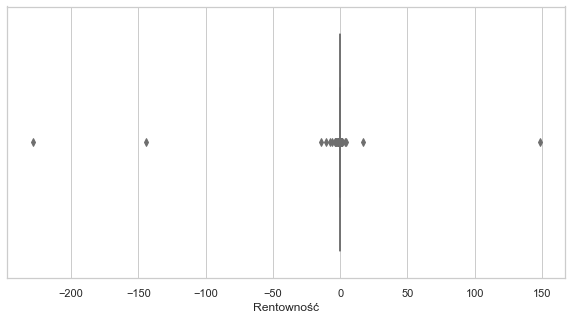

In [100]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='Rentowność', data=df, orient="v", color = 'violet')
plt.xlabel('Rentowność')
plt.savefig('boxplot_Rentowność.png')
plt.show()

C:\Users\misiak\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


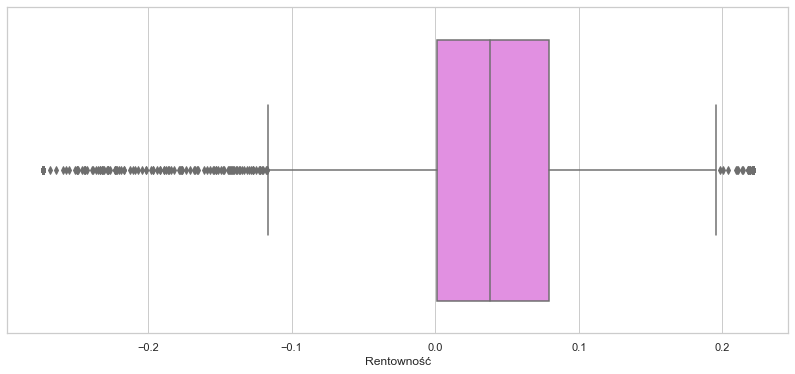

In [102]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(x='Rentowność', data=df1, orient="v", color = 'violet')
plt.xlabel('Rentowność')
plt.savefig('boxplot_Rentowność.png')
plt.show()

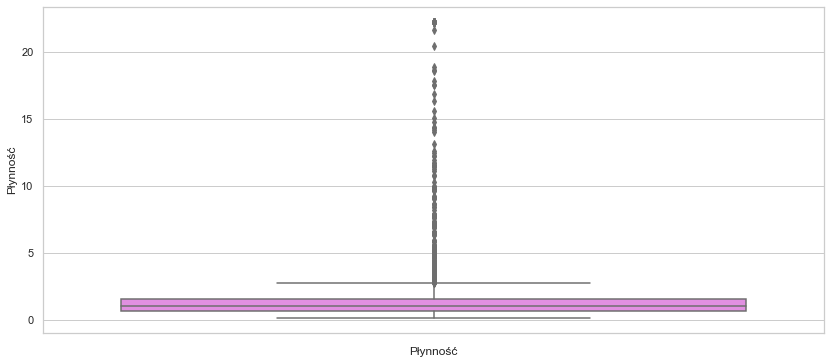

In [132]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(y='Płynność', data=df, orient="v", color = 'violet')
plt.xlabel('Płynność')
plt.savefig('boxplot_Płynność.png')
plt.show()

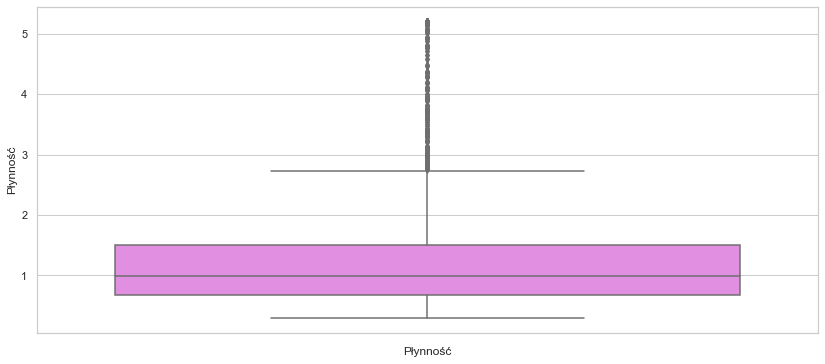

In [105]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(y='Płynność', data=df1, orient="v", color = 'violet')
plt.xlabel('Płynność')
plt.savefig('boxplot_Płynność.png')
plt.show()

C:\Users\misiak\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


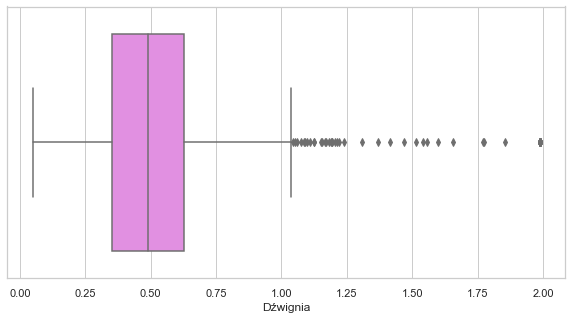

In [131]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='Dźwignia', data=df, orient="v", color = 'violet')
plt.xlabel('Dźwignia')
plt.savefig('boxplot_Dźwignia.png')
plt.show()

C:\Users\misiak\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


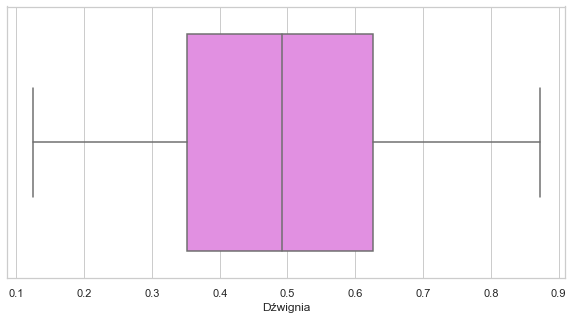

In [108]:
sns.set(style="whitegrid")
plt.figure(figsize=(10,5))
ax = sns.boxplot(x='Dźwignia', data=df1, orient="v", color = 'violet')
plt.xlabel('Dźwignia')
plt.savefig('boxplot_Dźwignia.png')
plt.show()

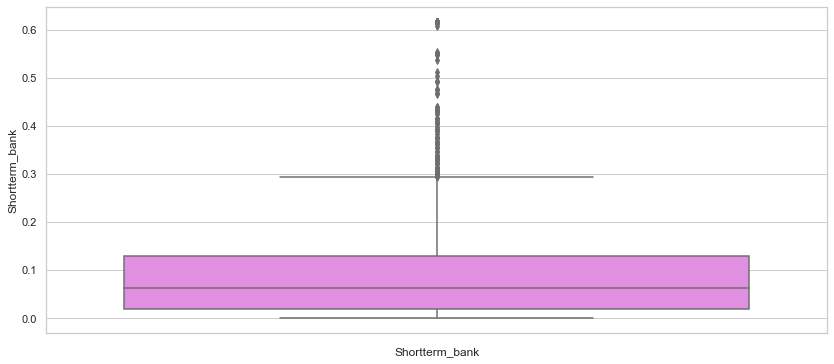

In [130]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(y='Shortterm_bank', data=df, orient="v", color = 'violet')
plt.xlabel('Shortterm_bank')
plt.savefig('boxplot_Shortterm_bank.png')
plt.show()

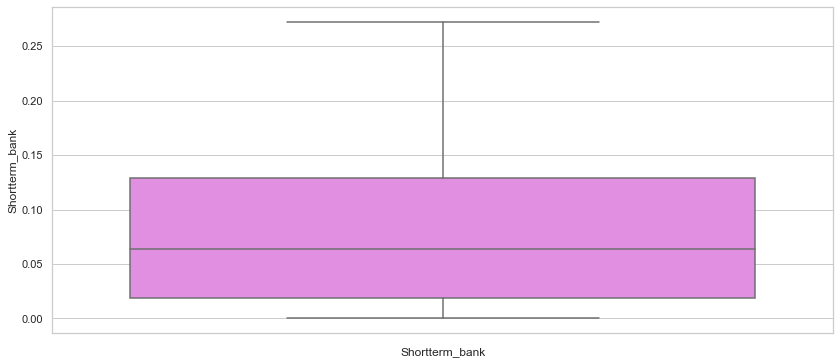

In [111]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(y='Shortterm_bank', data=df1, orient="v", color = 'violet')
plt.xlabel('Shortterm_bank')
plt.savefig('boxplot_Shortterm_bank.png')
plt.show()

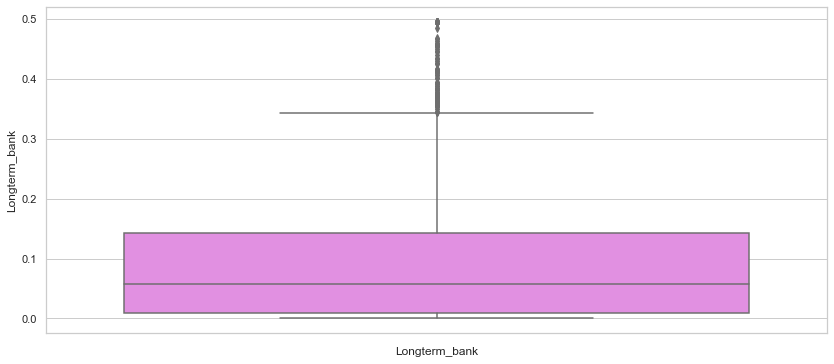

In [129]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(y='Longterm_bank', data=df, orient="v", color = 'violet')
plt.xlabel('Longterm_bank')
plt.savefig('boxplot_Longterm_bank.png')
plt.show()

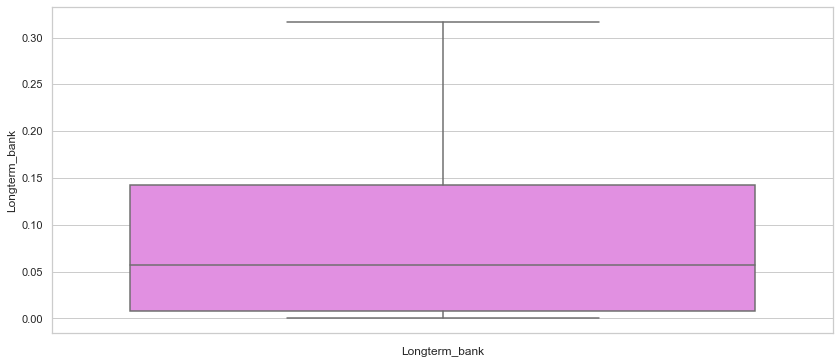

In [120]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(y='Longterm_bank', data=df1, orient="v", color = 'violet')
plt.xlabel('Longterm_bank')
plt.savefig('boxplot_Longterm_bank.png')
plt.show()

In [82]:
colnames = df.columns.values.tolist()
colnames

['company_id',
 'Przychody netto ze sprzedaży',
 'Zysk netto (strata netto)',
 'Aktywa ogółem',
 'Aktywa obrotowe',
 'Zapasy',
 'Gotówka i ekwiwalenty',
 'Zobowiązania ogółem',
 'Długoterminowe kredyty i pożyczki',
 'Zobowiązania krótkoterminowe',
 'Pożyczki krótkoterminowe',
 'Zobowiązania handlowe i inne',
 'Przepływy środków pieniężnych z działalności operacyjnej',
 'dependent',
 'Gotówka_płynność',
 'Rentowność',
 'Płynność',
 'Dźwignia',
 'Shortterm_bank',
 'Longterm_bank',
 'Cashflow',
 'Rozmiar',
 'Dźwignia_2',
 'Płynność_2',
 'Rentowność_2',
 'Longterm_bank_2',
 'sector_1',
 'sector_2',
 'sector_3',
 'sector_4',
 'sector_5',
 'sector_7',
 'Rok_2015',
 'Rok_2016',
 'Rok_2017',
 'Rok_2018',
 'Rok_2019',
 'Rok_2020',
 'Rok_2021',
 'Rok_2022']

In [488]:
df1.corr(method = 'pearson')

,Rok,Przepływy środków pieniężnych z działalności operacyjnej,sector,dependent,Gotówka_płynność,Rentowność,Płynność,Dźwignia,Shortterm_bank,Longterm_bank,Cashflow,Rozmiar,GDP_Growth,CPI,Dźwignia_2,Płynność_2,Rentowność_2,Longterm_bank_2
Rok,1.000000,0.067107,-0.019566,0.000082,0.073459,0.003620,-0.038545,0.026522,0.007358,0.055193,0.010663,0.089564,0.002278,0.804993,0.015202,-0.049928,0.017670,0.020223
Przepływy środków pieniężnych z działalności operacyjnej,0.067107,1.000000,-0.013578,-0.052726,-0.044855,0.004878,-0.028006,-0.009024,-0.016206,0.057729,0.030349,0.470695,0.004591,0.088941,-0.006020,-0.009420,-0.006995,-0.002724
sector,-0.019566,-0.013578,1.000000,-0.047698,0.103719,-0.019141,-0.001634,0.035249,0.026761,-0.067015,-0.039058,-0.120512,-0.006805,-0.031368,0.024912,-0.007124,0.032210,-0.015249
dependent,0.000082,-0.052726,-0.047698,1.000000,-0.117588,-0.070152,-0.122709,0.066311,0.178996,0.072218,-0.069363,0.013612,0.008165,-0.030613,-0.009176,-0.046628,0.025476,0.110360
Gotówka_płynność,0.073459,-0.044855,0.103719,-0.117588,1.000000,0.017545,0.183711,-0.011531,-0.040572,0.003140,0.031004,-0.235442,-0.032563,0.065691,-0.006325,0.030757,-0.001844,0.111834
Rentowność,0.003620,0.004878,-0.019141,-0.070152,0.017545,1.000000,0.006824,-0.707084,-0.436028,-0.073795,0.072822,0.063831,0.004059,0.008909,-0.725917,-0.001331,-0.623685,-0.053839
Płynność,-0.038545,-0.028006,-0.001634,-0.122709,0.183711,0.006824,1.000000,-0.017646,-0.018810,-0.045623,-0.001707,-0.142613,-0.012644,-0.017762,-0.006256,0.915342,-0.004028,-0.005113
Dźwignia,0.026522,-0.009024,0.035249,0.066311,-0.011531,-0.707084,-0.017646,1.000000,0.212477,0.142318,-0.085325,-0.096417,-0.019973,0.004817,0.951847,-0.005461,0.787567,0.054484
Shortterm_bank,0.007358,-0.016206,0.026761,0.178996,-0.040572,-0.436028,-0.018810,0.212477,1.000000,0.001155,-0.286769,-0.098806,0.017744,-0.002968,0.046128,-0.005313,0.311899,-0.001926
Longterm_bank,0.055193,0.057729,-0.067015,0.072218,0.003140,-0.073795,-0.045623,0.142318,0.001155,1.000000,-0.377491,0.057207,-0.065996,0.040029,0.106318,-0.019210,0.106349,0.855955


In [471]:
df.corr(method='pearson')

,company_id,Rok,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,...,Shortterm_bank,Longterm_bank,Cashflow,Rozmiar,GDP_Growth,CPI,Dźwignia_2,Płynność_2,Rentowność_2,Longterm_bank_2
company_id,1.000000,-0.013324,-0.038417,-0.018506,-0.017934,-0.025483,-0.075609,-0.000086,-0.011406,0.008758,...,0.028130,-0.063737,-0.044450,-0.177868,-0.006331,-0.027981,0.030171,0.002625,0.037693,-0.015648
Rok,-0.013324,1.000000,0.063116,0.063991,0.063215,0.075019,0.059398,0.068253,0.072809,0.059650,...,0.007358,0.055193,0.010663,0.089564,0.002278,0.804993,0.015202,-0.049928,0.017670,0.020223
Przychody netto ze sprzedaży,-0.038417,0.063116,1.000000,0.724183,0.872910,0.949761,0.939567,0.758302,0.858676,0.681337,...,-0.012466,0.043954,0.016568,0.437321,0.014474,0.089960,-0.006212,-0.009814,-0.007272,-0.003670
Zysk netto (strata netto),-0.018506,0.063991,0.724183,1.000000,0.641625,0.781915,0.793077,0.639633,0.626628,0.408348,...,-0.010596,0.012153,0.016159,0.198673,0.035377,0.092938,-0.008400,-0.003869,-0.005898,-0.001829
Aktywa ogółem,-0.017934,0.063215,0.872910,0.641625,1.000000,0.928646,0.784469,0.824883,0.983416,0.863933,...,-0.013722,0.067596,0.017118,0.503709,0.015309,0.081433,-0.006561,-0.010285,-0.007688,-0.002788
Aktywa obrotowe,-0.025483,0.075019,0.949761,0.781915,0.928646,1.000000,0.909941,0.865590,0.926568,0.726161,...,-0.011703,0.042288,0.015812,0.440391,0.021045,0.101592,-0.006271,-0.009716,-0.007389,-0.003787
Zapasy,-0.075609,0.059398,0.939567,0.793077,0.784469,0.909941,1.000000,0.670744,0.763526,0.549813,...,-0.009155,0.025089,0.012169,0.342212,0.019368,0.085446,-0.004969,-0.007857,-0.005813,-0.003531
Gotówka i ekwiwalenty,-0.000086,0.068253,0.758302,0.639633,0.824883,0.865590,0.670744,1.000000,0.831421,0.664806,...,-0.013156,0.042885,0.018411,0.415586,0.019376,0.093520,-0.005807,-0.008581,-0.006819,-0.003091
Zobowiązania ogółem,-0.011406,0.072809,0.858676,0.626628,0.983416,0.926568,0.763526,0.831421,1.000000,0.899210,...,-0.009122,0.079130,0.015815,0.503184,0.012903,0.089276,-0.004086,-0.010614,-0.006886,-0.002254
Długoterminowe kredyty i pożyczki,0.008758,0.059650,0.681337,0.408348,0.863933,0.726161,0.549813,0.664806,0.899210,1.000000,...,-0.013767,0.136973,0.016470,0.512650,0.004136,0.061207,-0.006476,-0.010274,-0.007581,0.000949


In [338]:
df.groupby(["Rok"])['Rozmiar'].describe()

,count,mean,std,min,25%,50%,75%,max
Rok,,,,,,,,
2014,246.0,12.281510,1.942506,4.468090,11.299286,12.129139,13.374948,18.008267
2015,249.0,12.397460,1.881141,7.085307,11.361463,12.265049,13.512173,17.931225
2016,248.0,12.548595,1.751821,8.025693,11.422967,12.340562,13.614330,18.027253
2017,269.0,12.432737,1.867204,7.190194,11.327644,12.303077,13.640540,18.094715
2018,285.0,12.514220,1.997597,5.384495,11.415941,12.377607,13.711057,18.589504
2019,284.0,12.551599,1.972027,4.499810,11.356970,12.466065,13.743891,18.588621
2020,275.0,12.555626,2.000978,2.639057,11.404902,12.500463,13.685660,18.246899
2021,273.0,12.691754,1.977984,3.231595,11.568663,12.597939,13.753284,18.486038
2022,168.0,13.228014,2.033195,7.121252,11.871733,13.051972,14.459174,19.424055


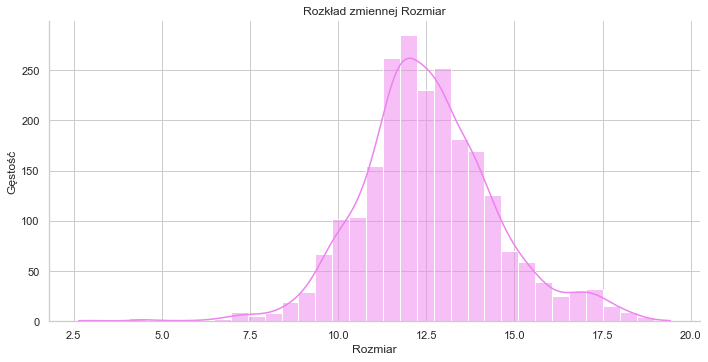

In [417]:
ax = sns.displot(
      data=df,
      x='Rozmiar',
      kind= "hist",
        kde = True,  
      aspect=2,
        height = 5,
      bins=35,
      color = 'violet'

    )
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Rozmiar')
plt.savefig('Rozklad_Rozmiar.png')
plt.show()

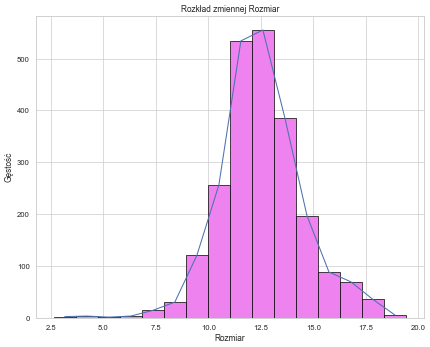

In [368]:
plt.figure(figsize = (10,8), dpi = 50)
plt.hist(x = df["Rozmiar"], color = 'violet',  bins = 16, edgecolor = 'black')
y,binedges = np.histogram(df['Rozmiar'], bins = 16)

bincenters = 0.5 * (binedges[1:] + binedges[:-1])
plt.plot(bincenters, y)
plt.xlabel('Rozmiar')
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Rozmiar')
plt.savefig('Rozlad_rozmiar.png')
plt.show()

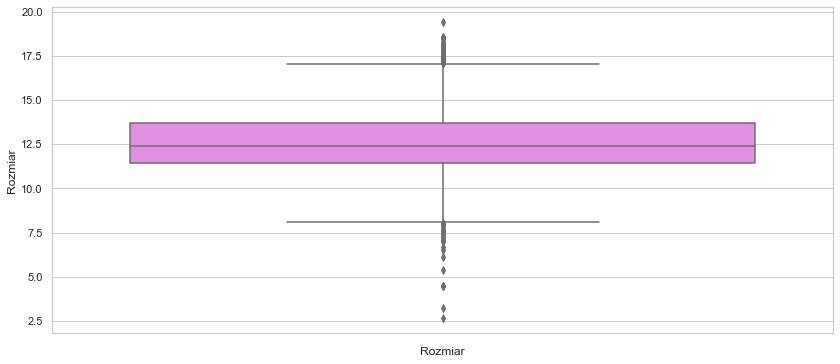

In [355]:
sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(y='Rozmiar', data=df, orient="v", color = 'violet')
plt.xlabel('Rozmiar')
plt.savefig('boxplot_rozmiar.png')
plt.show()

Text(0, 0.5, 'Zobowiązania handlowe')

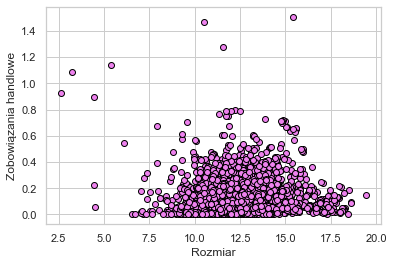

In [418]:
plt.scatter(df["Rozmiar"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Rozmiar')
plt.ylabel('Zobowiązania handlowe')

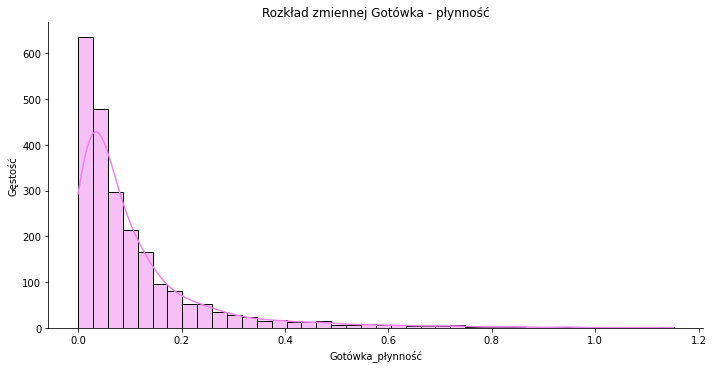

In [68]:
ax = sns.displot(
data=df,
x='Gotówka_płynność',
kind= "hist",
kde = True,  
aspect=2,
height = 5,
bins=40,
color = 'violet'

)
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Gotówka - płynność')
plt.savefig('Rozklad_Gotówka_-_płynność.png')
plt.show()

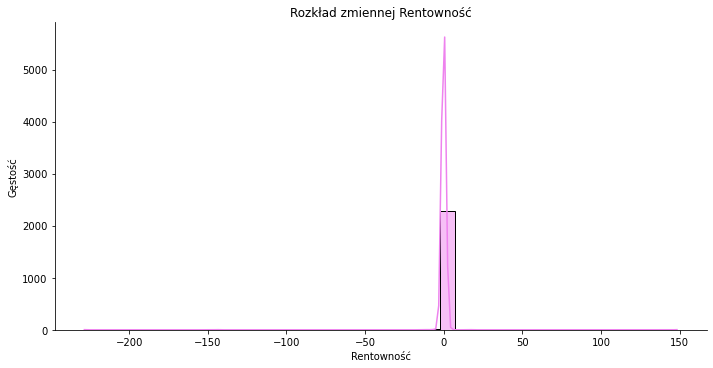

In [76]:
ax = sns.displot(
data=df,
x='Rentowność',
kind= "hist",
kde = True,  
aspect=2,
height = 5,
bins=40,
color = 'violet'

)
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Rentowność')
plt.savefig('Rozklad_Rentowność.png')
plt.show()

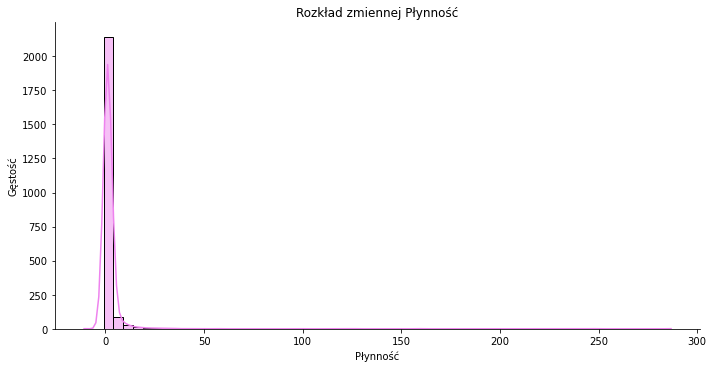

In [79]:
ax = sns.displot(
data=df,
x='Płynność',
kind= "hist",
kde = True,  
aspect=2,
height = 5,
bins=60,
color = 'violet'

)
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Płynność')
plt.savefig('Rozklad_Płynność.png')
plt.show()

In [390]:
def distributions(element):
    text = f"""
    ax = sns.displot(
      data=df,
      x=\'{element}\',
      kind= "hist",
        kde = True,  
      aspect=2,
        height = 5,
      bins=35,
      color = 'violet'

    )
    plt.ylabel('Gęstość')
    plt.title('Rozkład zmiennej {element}')
    plt.savefig('Rozklad_{element.replace(" ","_")}.png')
    plt.show()
    """
    print(text)

In [392]:
def generate_boxplot(element):
    text = f"""
    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))
    ax = sns.boxplot(y=\'{element}\', data=df, orient="v", color = 'violet')
    plt.xlabel(\'{element}\')
    plt.savefig('boxplot_{element.replace(" ","_")}.png')
    plt.show()
    """
    print(text)

In [376]:
colnames = df.columns.values.tolist()
colnames = colnames[16:26]
colnames

['Gotówka - płynność',
 'Rentowność',
 'Płynność',
 'Dźwignia',
 'Shortterm bank',
 'Longterm bank',
 'Cashflow',
 'Rozmiar',
 'GDP Growth',
 'CPI']

In [391]:
for element in colnames:
    distributions(element)


    ax = sns.displot(
      data=df,
      x='Gotówka - płynność',
      kind= "hist",
        kde = True,  
      aspect=2,
        height = 5,
      bins=35,
      color = 'violet'

    )
    plt.ylabel('Gęstość')
    plt.title('Rozkład zmiennej Gotówka - płynność')
    plt.savefig('Rozklad_Gotówka_-_płynność.png')
    plt.show()
    

    ax = sns.displot(
      data=df,
      x='Rentowność',
      kind= "hist",
        kde = True,  
      aspect=2,
        height = 5,
      bins=35,
      color = 'violet'

    )
    plt.ylabel('Gęstość')
    plt.title('Rozkład zmiennej Rentowność')
    plt.savefig('Rozklad_Rentowność.png')
    plt.show()
    

    ax = sns.displot(
      data=df,
      x='Płynność',
      kind= "hist",
        kde = True,  
      aspect=2,
        height = 5,
      bins=35,
      color = 'violet'

    )
    plt.ylabel('Gęstość')
    plt.title('Rozkład zmiennej Płynność')
    plt.savefig('Rozklad_Płynność.png')
    plt.show()
    

    ax = sns.displot(
      data=

In [393]:
for element in colnames:
    generate_boxplot(element)


    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))
    ax = sns.boxplot(y='Gotówka - płynność', data=df, orient="v", color = 'violet')
    plt.xlabel('Gotówka - płynność')
    plt.savefig('boxplot_Gotówka_-_płynność.png')
    plt.show()
    

    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))
    ax = sns.boxplot(y='Rentowność', data=df, orient="v", color = 'violet')
    plt.xlabel('Rentowność')
    plt.savefig('boxplot_Rentowność.png')
    plt.show()
    

    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))
    ax = sns.boxplot(y='Płynność', data=df, orient="v", color = 'violet')
    plt.xlabel('Płynność')
    plt.savefig('boxplot_Płynność.png')
    plt.show()
    

    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))
    ax = sns.boxplot(y='Dźwignia', data=df, orient="v", color = 'violet')
    plt.xlabel('Dźwignia')
    plt.savefig('boxplot_Dźwignia.png')
    plt.show()
    

    sns.set(style="whitegrid")
    plt.figure(figsize=(14,6))
    a

In [401]:
def scatter_plots(element):
    text=f"""
    plt.scatter(df[\"{element}\"], df["dependent"], color = 'violet', edgecolor = 'black')
    plt.xlabel(\'{element}\')
    plt.ylabel('Zobowiązania handlowe')"""
    print(text)


In [402]:
for element in colnames:
    scatter_plots(element)


    plt.scatter(df["Gotówka - płynność"], df["dependent"], color = 'violet', edgecolor = 'black')
    plt.xlabel('Gotówka - płynność')
    plt.ylabel('Zobowiązania handlowe')

    plt.scatter(df["Rentowność"], df["dependent"], color = 'violet', edgecolor = 'black')
    plt.xlabel('Rentowność')
    plt.ylabel('Zobowiązania handlowe')

    plt.scatter(df["Płynność"], df["dependent"], color = 'violet', edgecolor = 'black')
    plt.xlabel('Płynność')
    plt.ylabel('Zobowiązania handlowe')

    plt.scatter(df["Dźwignia"], df["dependent"], color = 'violet', edgecolor = 'black')
    plt.xlabel('Dźwignia')
    plt.ylabel('Zobowiązania handlowe')

    plt.scatter(df["Shortterm bank"], df["dependent"], color = 'violet', edgecolor = 'black')
    plt.xlabel('Shortterm bank')
    plt.ylabel('Zobowiązania handlowe')

    plt.scatter(df["Longterm bank"], df["dependent"], color = 'violet', edgecolor = 'black')
    plt.xlabel('Longterm bank')
    plt.ylabel('Zobowiązania handlowe')

    plt.scatter(d

Text(0, 0.5, 'Zobowiązania handlowe')

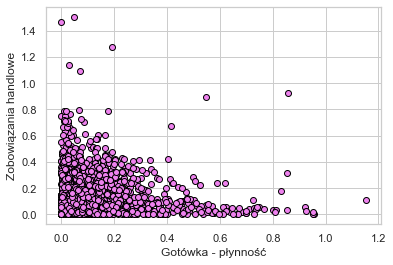

In [133]:

plt.scatter(df["Gotówka_płynność"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Gotówka - płynność')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

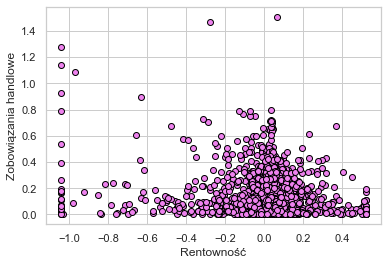

In [134]:
plt.scatter(df["Rentowność"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Rentowność')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

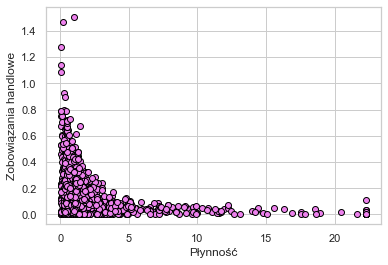

In [135]:
plt.scatter(df["Płynność"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Płynność')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

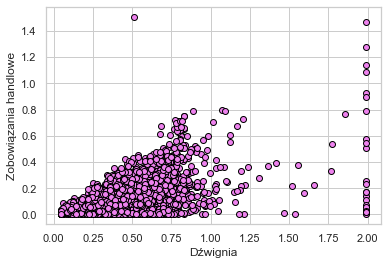

In [136]:
plt.scatter(df["Dźwignia"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Dźwignia')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

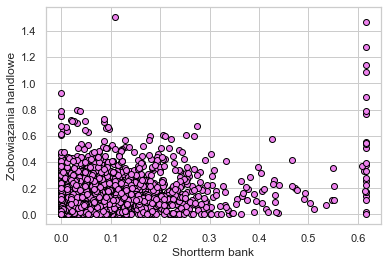

In [138]:
plt.scatter(df["Shortterm_bank"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Shortterm bank')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

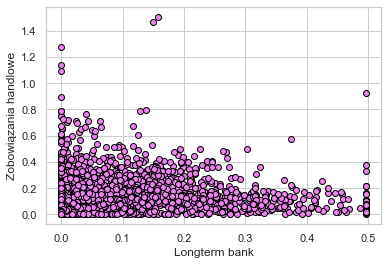

In [139]:
plt.scatter(df["Longterm_bank"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Longterm bank')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

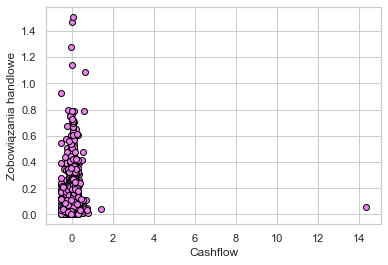

In [140]:
plt.scatter(df["Cashflow"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Cashflow')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

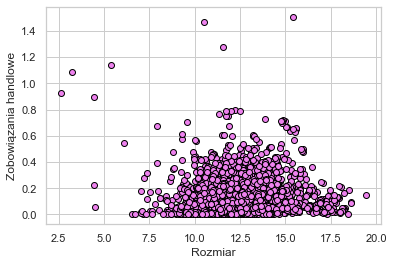

In [411]:
plt.scatter(df["Rozmiar"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('Rozmiar')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

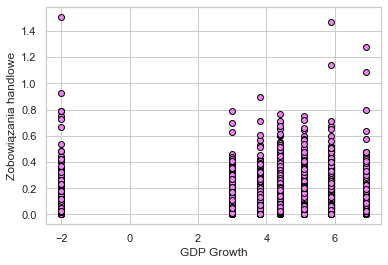

In [412]:
plt.scatter(df["GDP Growth"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('GDP Growth')
plt.ylabel('Zobowiązania handlowe')

Text(0, 0.5, 'Zobowiązania handlowe')

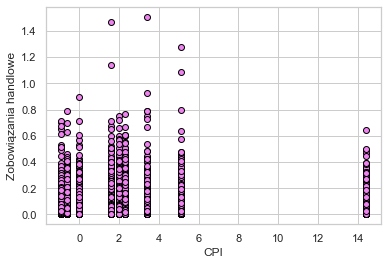

In [413]:
plt.scatter(df["CPI"], df["dependent"], color = 'violet', edgecolor = 'black')
plt.xlabel('CPI')
plt.ylabel('Zobowiązania handlowe')

In [462]:
df.head(10)

,company_id,Rok,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,...,Rentowność_2,Rozmiar_2,Shortterm_bank_2,Longterm_bank_2,sector_2,sector_3,sector_4,sector_5,sector_6,sector_7
0,1,2022,2451715.0,175636.0,4818709.0,938181.0,195860.0,475059.0,1111045.0,20100.0,...,0.001329,236.791055,0.000003,0.000017,0,0,0,0,0,0
1,2,2022,6790515.0,113573.0,3985674.0,2074617.0,1034891.0,164414.0,2296613.0,403187.0,...,0.000812,230.985800,0.055661,0.010233,0,0,0,0,0,0
2,3,2022,3666690.0,610373.0,2083016.0,1342661.0,549078.0,335761.0,854585.0,244536.0,...,0.085863,211.682928,0.001145,0.013782,0,0,0,0,0,0
3,4,2022,5415459.0,564701.0,8092527.0,3191785.0,771541.0,684969.0,5388217.0,1776129.0,...,0.004869,253.015203,0.000768,0.048170,0,0,0,0,0,0
4,6,2022,20198500.0,7593800.0,26963100.0,7852300.0,990100.0,4837900.0,11025600.0,1096400.0,...,0.079319,292.751410,0.000836,0.001653,0,0,0,0,0,0
5,7,2022,5930865.0,679652.0,3886143.0,1982890.0,985148.0,139418.0,1944557.0,894392.0,...,0.030587,230.217735,0.006014,0.052969,0,0,0,0,0,0
6,8,2022,33847000.0,4774000.0,53444000.0,13065000.0,8902000.0,1200000.0,21298000.0,5220000.0,...,0.007979,316.631594,0.000524,0.009540,0,0,0,0,0,0
7,10,2022,474016.0,52686.0,238007.0,112904.0,64620.0,20926.0,59491.0,0.0,...,0.049002,153.265771,0.000000,0.000000,0,0,0,0,0,0
8,11,2022,1282427.0,32447.0,967135.0,602585.0,469044.0,15339.0,329449.0,120835.0,...,0.001126,189.946098,0.005821,0.015610,0,0,0,0,0,0
9,12,2022,290322.0,30903.0,182416.0,123157.0,42316.0,48884.0,62269.0,0.0,...,0.028700,146.750088,0.000000,0.000000,0,0,0,0,0,0


In [510]:
def transform_to_square(df):
    df['Dźwignia_2'] = df['Dźwignia']*df['Dźwignia']
    df['Płynność_2'] = df['Płynność']*df['Płynność']
    df['Rentowność_2'] = df['Rentowność']*df['Rentowność']
    df['Longterm_bank_2'] = df['Longterm_bank']*df['Longterm_bank']
    #df['Rozmiar_2'] = df['Rozmiar']*df['Rozmiar']
    #df['Shortterm_bank_2'] = df['Shortterm_bank']*df['Shortterm_bank']
    return df

In [448]:
df['Dźwignia_2'] = df['Dźwignia']*df['Dźwignia']

In [450]:
df['Płynność_2'] = df['Płynność']*df['Płynność']

In [451]:
df['Rentowność_2'] = df['Rentowność']*df['Rentowność']

In [453]:
df['Rozmiar_2'] = df['Rozmiar']*df['Rozmiar']

In [456]:
df['Shortterm_bank_2'] = df['Shortterm_bank']*df['Shortterm_bank']

In [459]:
df['Longterm_bank_2'] = df['Longterm_bank']*df['Longterm_bank']

In [ ]:
#model

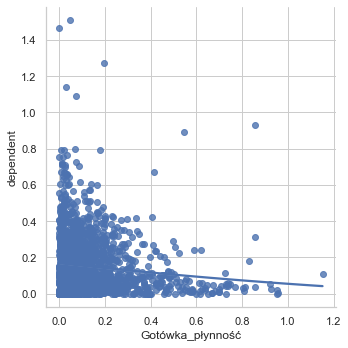

In [141]:
sns.lmplot(x = 'Gotówka_płynność', y = 'dependent', data = df,  ci = False, order = 2)

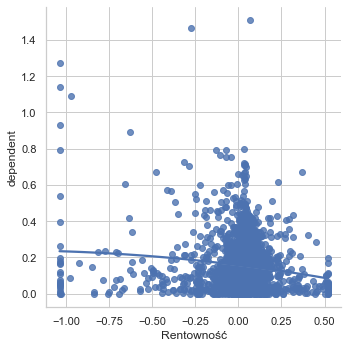

In [142]:
sns.lmplot(x = 'Rentowność', y = 'dependent', data = df,  ci = False, order = 2)

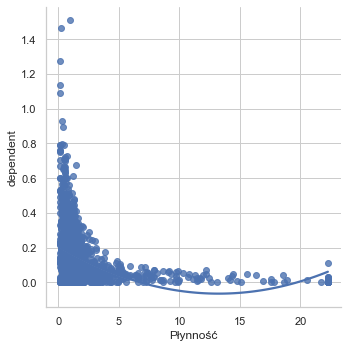

In [143]:
sns.lmplot(x = 'Płynność', y = 'dependent', data = df,  ci = False, order = 2)

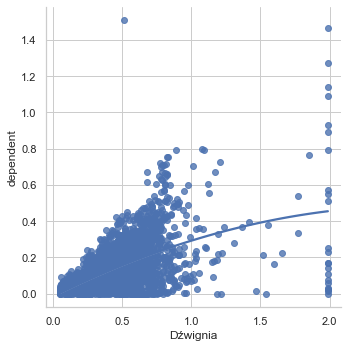

In [144]:
sns.lmplot(x = 'Dźwignia', y = 'dependent', data = df,  ci = False, order = 2)

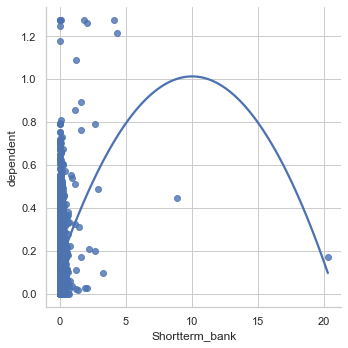

In [313]:
sns.lmplot(x = 'Shortterm_bank', y = 'dependent', data = df,  ci = False, order = 2)

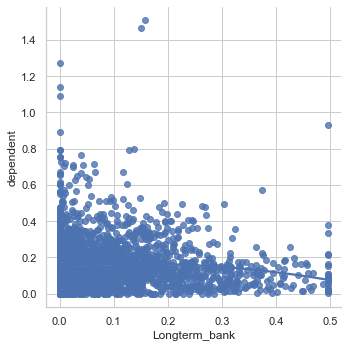

In [146]:
sns.lmplot(x = 'Longterm_bank', y = 'dependent', data = df,  ci = False, order = 2)

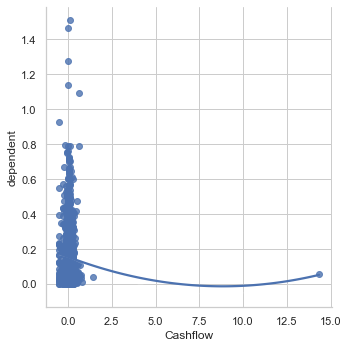

In [147]:
sns.lmplot(x = 'Cashflow', y = 'dependent', data = df,  ci = False, order = 2)

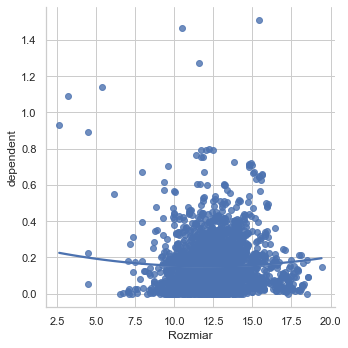

In [148]:
sns.lmplot(x = 'Rozmiar', y = 'dependent', data = df,  ci = False, order = 2)

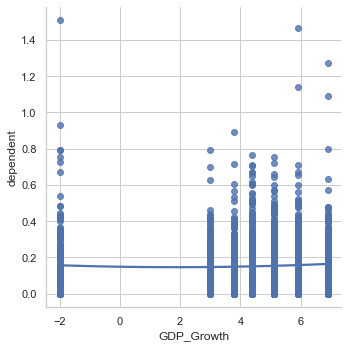

In [446]:
sns.lmplot(x = 'GDP_Growth', y = 'dependent', data = df,  ci = False, order = 2)

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 4453
Data columns (total 32 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3632 non-null   int64  
 1   Rok                                                       3632 non-null   int32  
 2   Przychody netto ze sprzedaży                              3631 non-null   float64
 3   Zysk netto (strata netto)                                 3632 non-null   float64
 4   Aktywa ogółem                                             3632 non-null   float64
 5   Aktywa obrotowe                                           3632 non-null   float64
 6   Zapasy                                                    3620 non-null   float64
 7   Należności handlowe i inne                                3632 non-null   float64
 8   Gotówka i ekwiwale

In [35]:
m1 = smf.ols(formula = 'dependent ~ Gotówka_płynność + Rentowność+ Rentowność_2 + Płynność + Płynność_2 + Dźwignia + Dźwignia_2 + Shortterm_bank + Longterm_bank+ Longterm_bank_2 + Cashflow + Rozmiar+Rok_2015+Rok_2016+Rok_2017+Rok_2018+Rok_2019+Rok_2020+Rok_2021+Rok_2022 +sector_1+ sector_2+sector_3+sector_4+sector_5+sector_7', data = df).fit()
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dependent   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     19.19
Date:                Wed, 10 May 2023   Prob (F-statistic):           1.84e-79
Time:                        08:36:08   Log-Likelihood:                 1426.4
No. Observations:                2265   AIC:                            -2799.
Df Residuals:                    2238   BIC:                            -2644.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1077      0.022      4.792      0.000       0.064       0.152
Gotówka_płynność    -0.0701      0.024     -2.943      0.003      -0.117      -0.023
Rentowność          -0.0116      0.001     -8.382      0.000      -0.014      -0.009
Rentowność_2       8.02e-05   9.25e-06      8.673      0.000    6.21e-05    9.83e-05
Płynność            -0.0062      0.001     -7.325      0.000      -0.008      -0.005
Płynność_2        2.522e-05   4.45e-06      5.670      0.000    1.65e-05    3.39e-05
Dźwignia             0.0413      0.003     11.950      0.000       0.034       0.048
Dźwignia_2          -0.0003   2.67e-05    -11.044      0.000      -0.000      -0.000
Shortterm_bank      -0.0720      0.010     -7.393      0.000      -0.091      -0.053
Longterm_bank       -0.1257      0.027     -4.640      0.000      -0.179      -0.073
Longterm_bank_2      0.0136      0.004      3.367      0.001       0.006       0.022
Cashflow            -0.0199      0.006     -3.272      0.001      -0.032      -0.008
Rozmiar              0.0043      0.002      2.626      0.009       0.001       0.008
Rok_2015            -0.0007      0.012     -0.061      0.951      -0.024       0.023
Rok_2016             0.0070      0.012      0.591      0.554      -0.016       0.030
Rok_2017             0.0206      0.012      1.762      0.078      -0.002       0.043
Rok_2018             0.0203      0.012      1.768      0.077      -0.002       0.043
Rok_2019             0.0099      0.012      0.857      0.391      -0.013       0.032
Rok_2020             0.0133      0.012      1.142      0.254      -0.010       0.036
Rok_2021             0.0148      0.012      1.269      0.205      -0.008       0.038
Rok_2022            -0.0106      0.013     -0.799      0.424      -0.037       0.015
sector_1            -0.0146      0.010     -1.472      0.141      -0.034       0.005
sector_2             0.0278      0.009      3.229      0.001       0.011       0.045
sector_3             0.0214      0.009      2.496      0.013       0.005       0.038
sector_4            -0.0230      0.011     -2.184      0.029      -0.044      -0.002
sector_5            -0.0716      0.013     -5.685      0.000      -0.096      -0.047
sector_7            -0.0251      0.010     -2.595      0.010      -0.044      -0.006
==============================================================================
Omnibus:                     1159.403   Durbin-Watson:                   0.824
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14551.247
Skew:                           2.114   Prob(JB):                         0.00
Kurtosis:                      14.675   Cond. No.                     1.80e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matr

In [36]:
hip3 = '(Rok_2015 = 0), (Rok_2016 = 0) '

In [37]:
f_test3 = m1.f_test(hip3)
f_test3

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=0.263623892984779, p=0.7682862880179989, df_denom=2.24e+03, df_num=2>

In [38]:
hip4 = '(Rok_2015 = 0), (Rok_2016 = 0), (Rok_2017 = 0) '

In [39]:
f_test4 = m1.f_test(hip4)
f_test4

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.4714891092559739, p=0.22035797595670145, df_denom=2.24e+03, df_num=3>

In [40]:
hip5 = '(Rok_2015 = 0), (Rok_2016 = 0), (Rok_2017 = 0), (Rok_2018 = 0) '

In [41]:
f_test5 = m1.f_test(hip5)
f_test5

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.6632342051583406, p=0.15581845372466796, df_denom=2.24e+03, df_num=4>

In [42]:
hip6 = '(Rok_2015 = 0), (Rok_2016 = 0), (Rok_2017 = 0), (Rok_2018 = 0), (Rok_2019 = 0) '

In [43]:
f_test6 = m1.f_test(hip6)
f_test6

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.33080816504282, p=0.24811153313968135, df_denom=2.24e+03, df_num=5>

In [44]:
hip7 = '(Rok_2015 = 0), (Rok_2016 = 0), (Rok_2017 = 0), (Rok_2018 = 0), (Rok_2019 = 0), (Rok_2020 = 0) '

In [45]:
f_test7 = m1.f_test(hip7)
f_test7

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.1324178521078394, p=0.34067894761485856, df_denom=2.24e+03, df_num=6>

In [161]:
hip8 = '(Rok_2015 = 0), (Rok_2016 = 0), (Rok_2017 = 0), (Rok_2018 = 0), (Rok_2019 = 0), (Rok_2020 = 0), (Rok_2021 = 0), (Rok_2022 = 0) '

In [184]:
f_test8 = m4.f_test(hip8)
f_test8

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.5610293697024062, p=0.13141368944338086, df_denom=2.28e+03, df_num=8>

In [62]:
f_test10 = m2.f_test(hip8)
f_test10

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.3286069950672834, p=0.2243026616182598, df_denom=2.24e+03, df_num=8>

In [63]:
f_test11 = m3.f_test(hip8)
f_test11

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.392723439835918, p=0.19449350337524898, df_denom=2.24e+03, df_num=8>

In [165]:
hip9 = '(sector_1 = 0), (sector_2 = 0), (sector_3 = 0), (sector_4 = 0), (sector_5 = 0), (sector_7 = 0)'

In [168]:
f_test9 = m3.f_test(hip9)
f_test9

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=18.414232897074847, p=5.4881417858576846e-21, df_denom=2.24e+03, df_num=6>

In [331]:
m2 = smf.ols(formula = 'dependent ~ Płynność + ROE + Shortterm_bank+Shortterm_bank_2 + Rozmiar+Naleznosci_handlowe+Zapasy_1+Rok_2011+Rok_2012+Rok_2013+ Rok_2014+Rok_2015+Rok_2016+Rok_2017+Rok_2018+Rok_2019+Rok_2020+Rok_2021+Rok_2022 +sector_1+ sector_2+sector_3+sector_4+sector_5+sector_7', data = df).fit(cov_type = 'HC0')
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dependent   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.271
Method:                 Least Squares   F-statistic:                     40.55
Date:                Mon, 15 May 2023   Prob (F-statistic):          6.10e-172
Time:                        15:35:56   Log-Likelihood:                 2311.8
No. Observations:                3463   AIC:                            -4572.
Df Residuals:                    3437   BIC:                            -4412.
Df Model:                          25                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.0007      0.023      0.031      0.975      -0.045       0.046
Płynność               -0.0074      0.001    -12.181      0.000      -0.009      -0.006
ROE                  1.606e-05   4.56e-06      3.519      0.000    7.11e-06     2.5e-05
Shortterm_bank          0.1559      0.037      4.197      0.000       0.083       0.229
Shortterm_bank_2       -0.0080      0.002     -4.377      0.000      -0.012      -0.004
Rozmiar                 0.0052      0.002      3.458      0.001       0.002       0.008
Naleznosci_handlowe     0.3914      0.022     17.794      0.000       0.348       0.435
Zapasy_1                0.1996      0.021      9.291      0.000       0.157       0.242
Rok_2011               -0.0074      0.013     -0.561      0.575      -0.033       0.019
Rok_2012               -0.0092      0.012     -0.763      0.446      -0.033       0.014
Rok_2013               -0.0246      0.012     -2.026      0.043      -0.048      -0.001
Rok_2014               -0.0307      0.012     -2.597      0.009      -0.054      -0.008
Rok_2015               -0.0189      0.012     -1.512      0.130      -0.043       0.006
Rok_2016               -0.0234      0.012     -1.885      0.059      -0.048       0.001
Rok_2017               -0.0158      0.013     -1.237      0.216      -0.041       0.009
Rok_2018               -0.0318      0.012     -2.624      0.009      -0.056      -0.008
Rok_2019               -0.0404      0.012     -3.327      0.001      -0.064      -0.017
Rok_2020               -0.0309      0.013     -2.458      0.014      -0.056      -0.006
Rok_2021               -0.0445      0.013     -3.545      0.000      -0.069      -0.020
Rok_2022               -0.0609      0.012     -4.879      0.000      -0.085      -0.036
sector_1                0.0051      0.007      0.785      0.432      -0.008       0.018
sector_2                0.0102      0.008      1.301      0.193      -0.005       0.025
sector_3                0.0461      0.007      6.718      0.000       0.033       0.060
sector_4                0.0449      0.011      4.247      0.000       0.024       0.066
sector_5               -0.0297      0.007     -4.053      0.000      -0.044      -0.015
sector_7                0.0078      0.007      1.092      0.275      -0.006       0.022
==============================================================================
Omnibus:                     1632.194   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18897.725
Skew:                           1.942   Prob(JB):                         0.00
Kurtosis:                      13.765   Cond. No.                     1.28e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust

In [179]:
m3 = smf.ols(formula = 'dependent ~ Gotówka_płynność + Rentowność + Płynność + Dźwignia + Shortterm_bank + Longterm_bank+ Cashflow + Rozmiar+Rok_2015+Rok_2016+Rok_2017+Rok_2018+Rok_2019+Rok_2020+Rok_2021+Rok_2022 +sector_1+ sector_2+sector_3+sector_4+sector_5+sector_7', data = df).fit()
m3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dependent   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     55.53
Date:                Thu, 11 May 2023   Prob (F-statistic):          1.34e-193
Time:                        11:52:01   Log-Likelihood:                 1696.5
No. Observations:                2297   AIC:                            -3347.
Df Residuals:                    2274   BIC:                            -3215.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0525      0.021     -2.493      0.013      -0.094      -0.011
Gotówka_płynność    -0.0533      0.022     -2.403      0.016      -0.097      -0.010
Rentowność           0.0243      0.016      1.532      0.126      -0.007       0.055
Płynność            -0.0019      0.001     -1.788      0.074      -0.004       0.000
Dźwignia             0.3565      0.013     27.309      0.000       0.331       0.382
Shortterm_bank      -0.1785      0.030     -6.027      0.000      -0.237      -0.120
Longterm_bank       -0.3794      0.026    -14.485      0.000      -0.431      -0.328
Cashflow            -0.0049      0.028     -0.173      0.863      -0.060       0.050
Rozmiar              0.0061      0.001      4.136      0.000       0.003       0.009
Rok_2015             0.0016      0.010      0.154      0.877      -0.019       0.022
Rok_2016             0.0055      0.010      0.528      0.597      -0.015       0.026
Rok_2017             0.0082      0.010      0.792      0.428      -0.012       0.028
Rok_2018             0.0058      0.010      0.572      0.567      -0.014       0.026
Rok_2019            -0.0087      0.010     -0.852      0.394      -0.029       0.011
Rok_2020             0.0022      0.010      0.211      0.833      -0.018       0.022
Rok_2021             0.0013      0.010      0.124      0.902      -0.019       0.021
Rok_2022            -0.0258      0.012     -2.191      0.029      -0.049      -0.003
sector_1             0.0105      0.009      1.171      0.242      -0.007       0.028
sector_2             0.0437      0.008      5.643      0.000       0.028       0.059
sector_3             0.0386      0.008      5.039      0.000       0.024       0.054
sector_4            -0.0171      0.010     -1.788      0.074      -0.036       0.002
sector_5            -0.0588      0.011     -5.275      0.000      -0.081      -0.037
sector_7             0.0038      0.009      0.446      0.656      -0.013       0.021
==============================================================================
Omnibus:                      681.001   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15301.069
Skew:                           0.859   Prob(JB):                         0.00
Kurtosis:                      15.527   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [182]:
m4 = smf.ols(formula = 'dependent ~ Gotówka_płynność + Rentowność + Płynność + Dźwignia + Shortterm_bank + Longterm_bank + Rozmiar+Rok_2015+Rok_2016+Rok_2017+Rok_2018+Rok_2019+Rok_2020+Rok_2021+Rok_2022 +sector_1+ sector_2+sector_3+sector_4+sector_5+sector_7', data = df).fit()
m4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dependent   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     58.20
Date:                Thu, 11 May 2023   Prob (F-statistic):          1.76e-194
Time:                        11:54:49   Log-Likelihood:                 1696.5
No. Observations:                2297   AIC:                            -3349.
Df Residuals:                    2275   BIC:                            -3223.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0526      0.021     -2.499      0.013      -0.094      -0.011
Gotówka_płynność    -0.0538      0.022     -2.455      0.014      -0.097      -0.011
Rentowność           0.0231      0.014      1.603      0.109      -0.005       0.051
Płynność            -0.0019      0.001     -1.780      0.075      -0.004       0.000
Dźwignia             0.3565      0.013     27.315      0.000       0.331       0.382
Shortterm_bank      -0.1784      0.030     -6.027      0.000      -0.236      -0.120
Longterm_bank       -0.3797      0.026    -14.519      0.000      -0.431      -0.328
Rozmiar              0.0061      0.001      4.133      0.000       0.003       0.009
Rok_2015             0.0015      0.010      0.148      0.882      -0.019       0.022
Rok_2016             0.0056      0.010      0.534      0.593      -0.015       0.026
Rok_2017             0.0082      0.010      0.797      0.425      -0.012       0.028
Rok_2018             0.0059      0.010      0.583      0.560      -0.014       0.026
Rok_2019            -0.0087      0.010     -0.856      0.392      -0.029       0.011
Rok_2020             0.0021      0.010      0.205      0.838      -0.018       0.022
Rok_2021             0.0013      0.010      0.130      0.897      -0.019       0.022
Rok_2022            -0.0258      0.012     -2.191      0.029      -0.049      -0.003
sector_1             0.0103      0.009      1.158      0.247      -0.007       0.028
sector_2             0.0436      0.008      5.643      0.000       0.028       0.059
sector_3             0.0385      0.008      5.063      0.000       0.024       0.053
sector_4            -0.0169      0.009     -1.780      0.075      -0.035       0.002
sector_5            -0.0589      0.011     -5.289      0.000      -0.081      -0.037
sector_7             0.0037      0.009      0.436      0.663      -0.013       0.021
==============================================================================
Omnibus:                      680.383   Durbin-Watson:                   0.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15286.280
Skew:                           0.858   Prob(JB):                         0.00
Kurtosis:                      15.521   Cond. No.                         171.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [156]:
m3 = smf.ols(formula = 'dependent ~ Gotówka_płynność + Rentowność + Płynność + Dźwignia + Shortterm_bank + Longterm_bank + Cashflow + Rozmiar, data = df).fit()
m3.summary()

SyntaxError: EOL while scanning string literal (107483172.py, line 1)

In [114]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2297
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dependent         2297 non-null   float64
 1   Gotówka_płynność  2297 non-null   float64
 2   Rentowność        2297 non-null   float64
 3   Płynność          2297 non-null   float64
 4   Dźwignia          2297 non-null   float64
 5   Shortterm_bank    2297 non-null   float64
 6   Longterm_bank     2297 non-null   float64
 7   Cashflow          2265 non-null   float64
 8   Rozmiar           2297 non-null   float64
 9   Dźwignia_2        2297 non-null   float64
 10  Płynność_2        2297 non-null   float64
 11  Rentowność_2      2297 non-null   float64
 12  Longterm_bank_2   2297 non-null   float64
dtypes: float64(13)
memory usage: 251.2 KB


In [56]:
hip_p1 = '(Shortterm_bank = 0)'

In [57]:
t_test1 = m2.t_test(hip_p1)
t_test1

<class 'statsmodels.stats.contrast.ContrastResults'>
                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0039      0.004      0.892      0.373      -0.005       0.012

In [54]:
linear_reset(m2, power = 2, test_type = "fitted")

C:\Users\misiak\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=8.03791068760273, p-value=0.004580834210983984, df_denom=1>

In [322]:
linear_reset(m2, power = 2, test_type = "fitted")

C:\Users\misiak\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=47.03164358728351, p-value=6.9849803823220224e-12, df_denom=1>

In [180]:
linear_reset(m3, power = 2, test_type = "fitted")

C:\Users\misiak\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=32.828466920255806, p-value=1.0065992359879014e-08, df_denom=1>

In [183]:
linear_reset(m4, power = 2, test_type = "fitted")

C:\Users\misiak\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=32.52177172748256, p-value=1.1786470305183746e-08, df_denom=1>

In [435]:
colnames = df.columns.values.tolist()
colnames

['company_id',
 'Rok',
 'Przychody netto ze sprzedaży',
 'Zysk netto (strata netto)',
 'Aktywa ogółem',
 'Aktywa obrotowe',
 'Zapasy',
 'Gotówka i ekwiwalenty',
 'Zobowiązania ogółem',
 'Długoterminowe kredyty i pożyczki',
 'Zobowiązania krótkoterminowe',
 'Pożyczki krótkoterminowe',
 'Zobowiązania handlowe i inne',
 'Przepływy środków pieniężnych z działalności operacyjnej',
 'sector',
 'dependent',
 'Gotówka_płynność',
 'Rentowność',
 'Płynność',
 'Dźwignia',
 'Shortterm_bank',
 'Longterm_bank',
 'Cashflow',
 'Rozmiar',
 'GDP_Growth',
 'CPI']

In [30]:
print(df['sector'].unique())

[1 2 3 4 5 6 7]


In [83]:
nan_count = df.isna().sum().sum()
nan_count

0

In [94]:
count_2014 = (df.index == 2014).sum()
#count_2015 = (df.index == '9th').sum()
#count_2016 = (df.index == '9th').sum()
#count_2017 = (df.index == '9th').sum()
#count_2018 = df.index == '9th'.sum()
#count_2019 = df.index == '9th'.sum()
#count_2020 = df.index == '9th'.sum()
#count_2021 = df.index == '9th'.sum()
#count_2022 = df.index == '9th'.sum()

In [77]:
df = df.dropna(how='any')

In [84]:
df[df['index'].isna()]

Bilans,company_id,index,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,Zobowiązania krótkoterminowe,Pożyczki krótkoterminowe,Zobowiązania handlowe i inne,Przepływy środków pieniężnych z działalności operacyjnej,sector


In [85]:
df[df['Zobowiązania handlowe i inne'].isna()]

Bilans,company_id,index,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Gotówka i ekwiwalenty,Zobowiązania ogółem,Długoterminowe kredyty i pożyczki,Zobowiązania krótkoterminowe,Pożyczki krótkoterminowe,Zobowiązania handlowe i inne,Przepływy środków pieniężnych z działalności operacyjnej,sector


In [476]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 0 to 2296
Data columns (total 30 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                2297 non-null   int64  
 1   Rok                                                       2297 non-null   int32  
 2   Przychody netto ze sprzedaży                              2297 non-null   float64
 3   Zysk netto (strata netto)                                 2297 non-null   float64
 4   Aktywa ogółem                                             2297 non-null   float64
 5   Aktywa obrotowe                                           2297 non-null   float64
 6   Zapasy                                                    2297 non-null   float64
 7   Gotówka i ekwiwalenty                                     2297 non-null   float64
 8   Zobowiązania ogółe

In [ ]:
346
263

In [ ]:
71 finanse

In [ ]:
(chemia) sadovaya - brak na emis
pepco nv brak
resbud brak 

In [ ]:
inne usługi - dobra i uslugi
nowe technologie - technologie
przemysl surowcowy - chemia i surowce

In [160]:
ready_df = pd.read_excel('C:/Users/misiak/OneDrive - Hewlett Packard Enterprise/Desktop/Studia/Ready_database.xlsx')

In [252]:
tc_df = pd.read_excel('C:/Users/misiak/OneDrive - Hewlett Packard Enterprise/Desktop/Studia/Ready_database_1.xlsx')

In [201]:
na = tc_df[tc_df.isna().any(axis=1)]
na

,company_id,Rok,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Należności handlowe i inne,Gotówka i ekwiwalenty,Kapitał własny ogółem,...,Shortterm,Cashflow,Rozmiar,Należności_handlowe,Zapasy_1,ROE,ROS,dependent,Rozmiar_1,Potencjał wzrostu_1
130,12,2012,98172.00,5152.00,73862.00,33672.00,15448.00,10839.00,6714.00,23955.00,...,0.000000,0.000000,11.250105,0.144093,0.212478,0.315571,0.055185,0.261907,11.585525,0.008460
210,20,2015,1815634.00,124423.00,1728238.00,484355.00,128158.00,215975.00,137147.00,1123809.00,...,0.033441,0.000000,14.247278,0.161769,0.097506,0.074017,0.038122,0.185933,14.536086,-0.017254
211,20,2014,2055616.00,78364.00,1539977.00,499241.00,150157.00,249121.00,29203.00,1058736.00,...,0.056446,0.000000,14.264682,0.187862,0.079887,0.083168,0.041098,0.159824,14.545844,0.059348
212,20,2013,2075772.00,85310.00,1567014.00,562336.00,125184.00,294383.00,68184.00,1025749.00,...,0.012559,0.000000,14.207029,0.180071,0.078478,0.115289,0.053488,0.183685,14.587948,-0.047442
213,20,2012,2165037.00,115804.00,1479225.00,444450.00,116087.00,266365.00,58686.00,1004463.00,...,0.000000,0.000000,14.255633,0.161228,0.058175,0.191641,0.087605,0.165131,14.629688,0.048412
265,25,2012,11720.17,-1829.05,34411.20,16886.14,5441.24,5706.60,1895.66,23672.81,...,0.000000,0.000000,10.380125,0.119610,0.287275,0.241950,0.248306,0.154526,10.230919,0.827118
516,50,2012,391254.49,14186.68,231300.68,78844.22,22327.96,51593.11,945.73,57368.80,...,0.067480,0.000000,12.434276,0.267968,0.098929,-0.004719,-0.000971,0.237672,12.866993,0.509039
538,52,2012,57995.29,-3681.40,171427.10,38569.91,15269.31,11723.36,3837.32,40523.05,...,0.122719,0.000000,12.064997,0.068078,0.101264,-0.146980,-0.100979,0.134936,11.069085,0.456708
581,56,2012,131783.00,8198.00,110429.00,88338.00,21005.00,18127.00,26998.00,71427.00,...,0.000000,0.067870,11.527548,0.085865,0.215328,-0.078856,-0.044836,0.062112,11.619131,-0.231673
634,62,2014,431949.96,20253.56,222167.34,178364.92,133562.67,38052.43,4674.37,70577.00,...,0.126627,0.000000,12.091945,0.147772,0.610095,0.458662,0.069683,0.153689,12.786172,0.282427


In [50]:
uniq = ready_df['sector'].unique()
uniq

array([1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [184]:
uniq1 = tc_df['sector'].unique()
uniq1

array([ 1., nan,  2.,  3.,  4.,  5.,  6.,  7.])

In [188]:
na1 = tc_df[tc_df['sector'].isna()]
na1

,company_id,Rok,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Należności handlowe i inne,Gotówka i ekwiwalenty,Kapitał własny ogółem,...,Shortterm,Cashflow,Rozmiar,Należności_handlowe,Zapasy_1,ROE,ROS,dependent,Rozmiar_1,Potencjał wzrostu_1


In [101]:
from pandas.table.plotting import table

ModuleNotFoundError: No module named 'pandas.table'

In [94]:
descriptive_1 = ready_df.groupby(["Rok"])['dependent'].describe(include ='object')
descriptive_1

,count,mean,std,min,25%,50%,75%,max
Rok,,,,,,,,
2012,226.0,0.177592,0.136754,0.0,0.074354,0.138745,0.230570,0.670162
2013,254.0,0.157678,0.129771,0.0,0.067295,0.125206,0.198257,0.670162
2014,263.0,0.145361,0.124069,0.0,0.055309,0.117365,0.188490,0.670162
2015,268.0,0.141310,0.123680,0.0,0.056580,0.115190,0.191180,0.670162
2016,268.0,0.147655,0.121441,0.0,0.058672,0.120975,0.197535,0.670162
2017,276.0,0.158209,0.137139,0.0,0.062144,0.129650,0.206666,0.670162
2018,279.0,0.157286,0.133859,0.0,0.061239,0.135421,0.213832,0.670162
2019,300.0,0.145271,0.131037,0.0,0.048890,0.114928,0.202825,0.670162
2020,298.0,0.144245,0.131464,0.0,0.047932,0.113760,0.208138,0.670162


In [93]:
plt.savefig("Descriptive_statistics.png")

<Figure size 432x288 with 0 Axes>

In [54]:
ready_df.groupby(["sector"])["dependent"].describe()[['count','mean']]

,count,mean
sector,,
1,299.0,0.142021
2,452.0,0.178697
3,504.0,0.155506
4,241.0,0.130527
5,158.0,0.090597
6,1002.0,0.159467
7,375.0,0.126882


C:\Users\misiak\Anaconda3\lib\site-packages\seaborn\_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


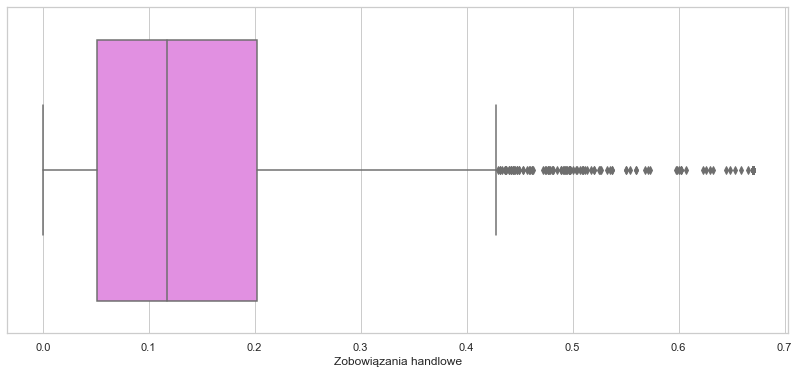

In [123]:
%matplotlib inline

sns.set(style="whitegrid")
plt.figure(figsize=(14,6))
ax = sns.boxplot(x='dependent', data=ready_df, orient="v", color = 'violet')
plt.xlabel('Zobowiązania handlowe')
plt.savefig('boxplot.png')
plt.show()

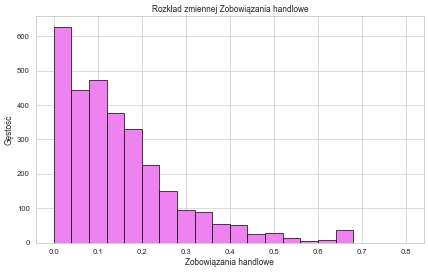

In [129]:
plt.figure(figsize = (10,6), dpi = 50)
plt.hist(x = ready_df["dependent"], color = 'violet', range = (0,0.8), bins = 20, edgecolor = 'black' )
plt.xlabel('Zobowiązania handlowe')
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Zobowiązania handlowe')
plt.savefig('Rozlad_dependent.png')
plt.show()

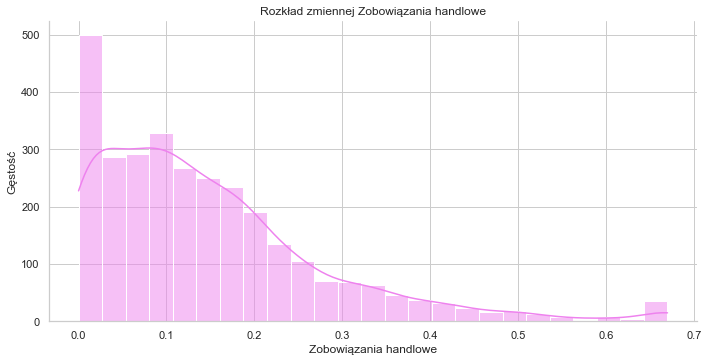

In [137]:
ax = sns.displot(
data=ready_df,
x='dependent',
kind= "hist",
kde = True,  
aspect=2,
height = 5,
bins=25,
color = 'violet'

)
plt.ylabel('Gęstość')
plt.title('Rozkład zmiennej Zobowiązania handlowe')
plt.xlabel('Zobowiązania handlowe')
plt.savefig('Rozklad_zobowiązania.png')
plt.show()

In [222]:
ready_df = wins(ready_df)

In [253]:
tc_df = wins(tc_df)

In [190]:
ready_df = pd.get_dummies(ready_df, columns = ['sector'])

KeyError: "None of [Index(['sector'], dtype='object')] are in the [columns]"

In [254]:
tc_df = pd.get_dummies(tc_df, columns = ['sector'])

In [224]:
ready_df = ready_df.drop(columns = ['sector_6'])

KeyError: "['sector_6'] not found in axis"

In [255]:
tc_df = tc_df.drop(columns = ['sector_6'])

In [174]:
ready_df = pd.get_dummies(ready_df, columns = ['Rok'], drop_first = True)

In [256]:
tc_df = pd.get_dummies(tc_df, columns = ['Rok'], drop_first = True)

In [206]:
tc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3027 entries, 0 to 3026
Data columns (total 46 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3027 non-null   int64  
 1   Przychody netto ze sprzedaży                              3027 non-null   float64
 2   Zysk netto (strata netto)                                 3027 non-null   float64
 3   Aktywa ogółem                                             3027 non-null   float64
 4   Aktywa obrotowe                                           3027 non-null   float64
 5   Zapasy                                                    3027 non-null   float64
 6   Należności handlowe i inne                                3027 non-null   float64
 7   Gotówka i ekwiwalenty                                     3027 non-null   float64
 8   Kapitał własny ogó

In [243]:
tc_df_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3027 entries, 0 to 3026
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gotówka_płynność     3027 non-null   float64
 1   Potencjał_wzrostu    3027 non-null   float64
 2   Rentowność           3027 non-null   float64
 3   Płynność             3027 non-null   float64
 4   Dźwignia             3027 non-null   float64
 5   Shortterm            3027 non-null   float64
 6   Cashflow             3027 non-null   float64
 7   Rozmiar              3027 non-null   float64
 8   Należności_handlowe  3027 non-null   float64
 9   Zapasy_1             3027 non-null   float64
 10  ROE                  3027 non-null   float64
 11  ROS                  3027 non-null   float64
 12  dependent            3027 non-null   float64
 13  Rozmiar_1            3027 non-null   float64
 14  Potencjał_wzrostu_1  3027 non-null   float64
dtypes: float64(15)
memory usage: 354.9 KB


In [162]:
ready_df_1_corr = tc_df.drop(tc_df.iloc[:,:16], axis = 1)

In [242]:
tc_df_corr = tc_df.drop(tc_df.iloc[:,:17], axis = 1)

In [244]:
tc_df_corr = tc_df_corr.drop(columns = ['ROS', 'dependent'])

In [247]:
tc_df_corr = tc_df_corr.drop(columns = ['Rozmiar', 'Potencjał_wzrostu'])

In [164]:
ready_df_1_corr = ready_df_1_corr.drop(columns = ['sector', 'ROS', 'dependent'])

In [169]:
ready_df_1_corr = ready_df_1_corr.drop(columns = ['ROE', 'Płynność'])

In [248]:
ready_df_1_corr.describe()

,Gotówka_płynność,Potencjał_wzrostu,Rentowność,Dźwignia,Shortterm,Cashflow,Rozmiar,Należności_handlowe,Zapasy_1
count,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000
mean,0.095324,0.177266,0.027308,0.480367,0.082548,0.063329,12.355793,0.189508,0.131081
std,0.100947,0.404277,0.107448,0.200225,0.079900,0.095632,1.695184,0.125343,0.131427
min,0.003542,-0.378930,-0.273443,0.122069,0.000000,-0.156030,9.396571,0.017144,0.000000
25%,0.023772,-0.042908,0.003274,0.338961,0.013273,0.007802,11.195964,0.091667,0.015379
50%,0.058454,0.085010,0.038735,0.473342,0.062180,0.068549,12.216162,0.166879,0.086203
75%,0.128262,0.272995,0.077281,0.621885,0.128969,0.123368,13.530111,0.268460,0.218187
max,0.382471,1.395676,0.217893,0.864572,0.274410,0.240535,15.742338,0.469510,0.429743


In [249]:
tc_df_corr.corr(method = 'pearson')

,Gotówka_płynność,Rentowność,Płynność,Dźwignia,Shortterm,Cashflow,Należności_handlowe,Zapasy_1,ROE,Rozmiar_1,Potencjał_wzrostu_1
Gotówka_płynność,1.000000,0.082865,0.505964,-0.203687,-0.259694,0.088099,-0.078126,-0.219349,0.079088,-0.216249,-0.005372
Rentowność,0.082865,1.000000,0.114753,-0.334827,-0.228372,0.522666,0.060680,0.103495,0.505431,0.297453,-0.021284
Płynność,0.505964,0.114753,1.000000,-0.444943,-0.289351,0.007907,-0.082307,-0.186885,0.054209,-0.320280,-0.007201
Dźwignia,-0.203687,-0.334827,-0.444943,1.000000,0.504895,-0.154705,0.164472,0.061503,-0.046485,0.098473,0.062512
Shortterm,-0.259694,-0.228372,-0.289351,0.504895,1.000000,-0.134984,0.070304,0.159769,-0.090465,-0.009087,0.080061
Cashflow,0.088099,0.522666,0.007907,-0.154705,-0.134984,1.000000,-0.057964,-0.030464,0.313245,0.319493,-0.000585
Należności_handlowe,-0.078126,0.060680,-0.082307,0.164472,0.070304,-0.057964,1.000000,-0.029855,0.066248,0.052628,-0.005965
Zapasy_1,-0.219349,0.103495,-0.186885,0.061503,0.159769,-0.030464,-0.029855,1.000000,0.075106,0.207306,-0.024556
ROE,0.079088,0.505431,0.054209,-0.046485,-0.090465,0.313245,0.066248,0.075106,1.000000,0.162071,0.015528
Rozmiar_1,-0.216249,0.297453,-0.320280,0.098473,-0.009087,0.319493,0.052628,0.207306,0.162071,1.000000,0.001385


In [165]:
ready_df_1_corr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3031 entries, 0 to 3030
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Gotówka_płynność     3031 non-null   float64
 1   Potencjał_wzrostu    3031 non-null   float64
 2   Rentowność           3031 non-null   float64
 3   Płynność             3031 non-null   float64
 4   Dźwignia             3031 non-null   float64
 5   Shortterm            3031 non-null   float64
 6   Cashflow             3031 non-null   float64
 7   Rozmiar              3031 non-null   float64
 8   Należności_handlowe  3031 non-null   float64
 9   Zapasy_1             3031 non-null   float64
 10  ROE                  3031 non-null   float64
dtypes: float64(11)
memory usage: 260.6 KB


In [167]:
ready_df_2_corr = ready_df_1_corr.drop(columns = ['Dźwignia'])

In [119]:
ready_df_3_corr = ready_df_2_corr.drop(columns = ['Cashflow'])

In [116]:
import seaborn as sns

<AxesSubplot:>

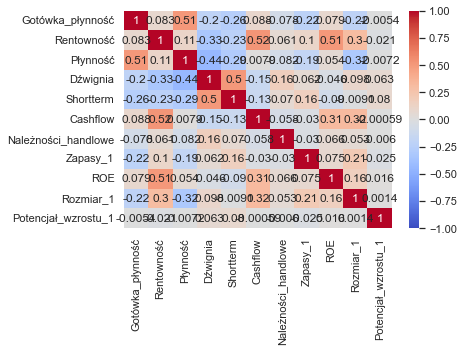

In [250]:
sns.heatmap(tc_df_corr.corr(method = 'pearson'), vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')

<AxesSubplot:>

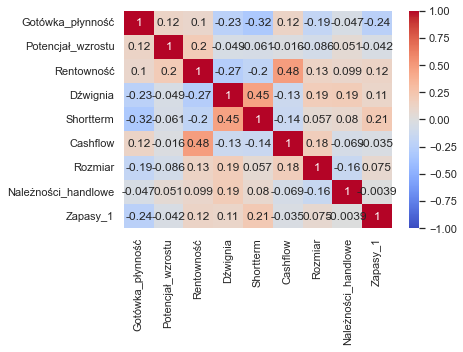

In [170]:
sns.heatmap(ready_df_1_corr.corr(method = 'pearson'), vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')

<AxesSubplot:>

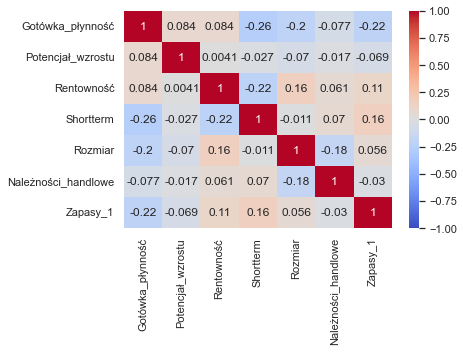

In [120]:
sns.heatmap(ready_df_3_corr.corr(method = 'pearson'), vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')

<AxesSubplot:>

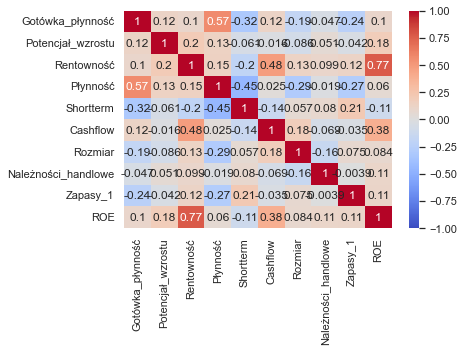

In [168]:
sns.heatmap(ready_df_2_corr.corr(method = 'pearson'), vmin = -1, vmax = 1, annot = True, cmap = 'coolwarm')

In [109]:
ready_df_2_corr.corr(method = 'pearson')

,Gotówka_płynność,Potencjał_wzrostu,Rentowność,Shortterm,Cashflow,Rozmiar,Należności_handlowe,Zapasy_1
Gotówka_płynność,1.000000,0.084381,0.083954,-0.258621,0.088968,-0.203798,-0.077383,-0.218150
Potencjał_wzrostu,0.084381,1.000000,0.004084,-0.026612,-0.077638,-0.069759,-0.017163,-0.068593
Rentowność,0.083954,0.004084,1.000000,-0.223881,0.519574,0.157971,0.061038,0.105430
Shortterm,-0.258621,-0.026612,-0.223881,1.000000,-0.135082,-0.010713,0.070293,0.161052
Cashflow,0.088968,-0.077638,0.519574,-0.135082,1.000000,0.188848,-0.057894,-0.030539
Rozmiar,-0.203798,-0.069759,0.157971,-0.010713,0.188848,1.000000,-0.176167,0.056320
Należności_handlowe,-0.077383,-0.017163,0.061038,0.070293,-0.057894,-0.176167,1.000000,-0.029572
Zapasy_1,-0.218150,-0.068593,0.105430,0.161052,-0.030539,0.056320,-0.029572,1.000000


In [91]:
ready_df_1_corr.corr(method = 'pearson')

,Gotówka_płynność,Potencjał_wzrostu,Rentowność,Dźwignia,Shortterm,Cashflow,Rozmiar,Należności_handlowe,Zapasy_1
Gotówka_płynność,1.000000,0.084381,0.083954,-0.201983,-0.258621,0.088968,-0.203798,-0.077383,-0.218150
Potencjał_wzrostu,0.084381,1.000000,0.004084,-0.062309,-0.026612,-0.077638,-0.069759,-0.017163,-0.068593
Rentowność,0.083954,0.004084,1.000000,-0.329882,-0.223881,0.519574,0.157971,0.061038,0.105430
Dźwignia,-0.201983,-0.062309,-0.329882,1.000000,0.504461,-0.154724,0.071236,0.165255,0.061896
Shortterm,-0.258621,-0.026612,-0.223881,0.504461,1.000000,-0.135082,-0.010713,0.070293,0.161052
Cashflow,0.088968,-0.077638,0.519574,-0.154724,-0.135082,1.000000,0.188848,-0.057894,-0.030539
Rozmiar,-0.203798,-0.069759,0.157971,0.071236,-0.010713,0.188848,1.000000,-0.176167,0.056320
Należności_handlowe,-0.077383,-0.017163,0.061038,0.165255,0.070293,-0.057894,-0.176167,1.000000,-0.029572
Zapasy_1,-0.218150,-0.068593,0.105430,0.061896,0.161052,-0.030539,0.056320,-0.029572,1.000000


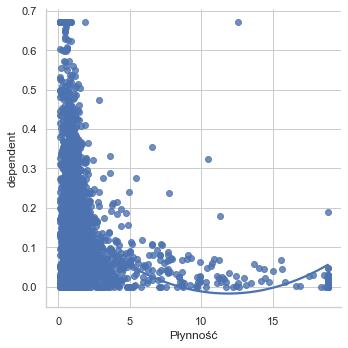

In [66]:
sns.lmplot(x = 'Płynność', y = 'dependent', data = ready_df,  ci = False, order = 2)

In [153]:
ready_df.describe()

,company_id,Przychody netto ze sprzedaży,Zysk netto (strata netto),Aktywa ogółem,Aktywa obrotowe,Zapasy,Należności handlowe i inne,Gotówka i ekwiwalenty,Kapitał własny ogółem,Zobowiązania ogółem,...,Rok_2015,Rok_2016,Rok_2017,Rok_2018,Rok_2019,Rok_2020,Rok_2021,Rok_2022,predictions,residuals
count,3031.000000,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.031000e+03,3.030000e+03,3.031000e+03,3.031000e+03,...,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3031.000000,3.031000e+03
mean,164.774992,1.890513e+06,7.641862e+04,2.084586e+06,6.966774e+05,2.065765e+05,2.371966e+05,1.512139e+05,1.037846e+06,1.045218e+06,...,0.088420,0.088420,0.091059,0.092049,0.098977,0.098317,0.099307,0.098317,0.147705,2.783799e-16
std,95.586428,8.858978e+06,8.295704e+05,9.015624e+06,3.089711e+06,1.207226e+06,1.019406e+06,6.696467e+05,4.817117e+06,4.313273e+06,...,0.283951,0.283951,0.287741,0.289143,0.298681,0.297792,0.299123,0.297792,0.062712,1.150619e-01
min,1.000000,-8.825000e+03,-5.828000e+06,2.532000e+01,2.495000e+01,0.000000e+00,-2.387700e+04,0.000000e+00,-5.577538e+06,8.520000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.139901,-3.447120e-01
25%,82.500000,6.805100e+04,2.185000e+02,7.876600e+04,3.459650e+04,2.439000e+03,1.086800e+04,3.307250e+03,3.521908e+04,2.860145e+04,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.106707,-7.115594e-02
50%,173.000000,2.198632e+05,7.330000e+03,2.179610e+05,1.030010e+05,2.177111e+04,3.584380e+04,1.339050e+04,1.050940e+05,1.055810e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.145049,-1.928384e-02
75%,248.000000,8.537988e+05,3.281800e+04,8.141560e+05,3.635800e+05,9.703250e+04,1.264065e+05,5.567950e+04,3.464850e+05,4.193621e+05,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185612,5.015505e-02
max,325.000000,2.785090e+08,3.545800e+07,2.727470e+08,1.178390e+08,4.477900e+07,3.790800e+07,2.140300e+07,1.388590e+08,1.338880e+08,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.405794,5.717534e-01


In [195]:
tc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3029 entries, 0 to 3028
Data columns (total 46 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   company_id                                                3029 non-null   int64  
 1   Przychody netto ze sprzedaży                              3029 non-null   float64
 2   Zysk netto (strata netto)                                 3029 non-null   float64
 3   Aktywa ogółem                                             3029 non-null   float64
 4   Aktywa obrotowe                                           3029 non-null   float64
 5   Zapasy                                                    3029 non-null   float64
 6   Należności handlowe i inne                                3029 non-null   float64
 7   Gotówka i ekwiwalenty                                     3028 non-null   float64
 8   Kapitał własny ogó

In [266]:
m1 = smf.ols(formula = 'dependent ~ Cashflow +Potencjał_wzrostu_1+ ROE + Shortterm+ Rozmiar_1 + Należności_handlowe + Zapasy_1+ Rok_2013+ Rok_2014+Rok_2015+ Rok_2016+ Rok_2017+ Rok_2018+ Rok_2019+ Rok_2020+ Rok_2021 + Rok_2022 +sector_1 + sector_2 + sector_3 +sector_4 + sector_5 + sector_7', data = tc_df).fit(cov_type = 'HC1')
m1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dependent   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     29.98
Date:                Thu, 18 May 2023   Prob (F-statistic):          7.13e-117
Time:                        23:15:47   Log-Likelihood:                 2236.4
No. Observations:                3027   AIC:                            -4425.
Df Residuals:                    3003   BIC:                            -4280.
Df Model:                          23                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0642      0.019     -3.457      0.001      -0.101      -0.028
Cashflow               -0.0548      0.020     -2.711      0.007      -0.094      -0.015
Potencjał_wzrostu_1 -6.554e-05   2.06e-05     -3.189      0.001      -0.000   -2.53e-05
ROE                    -0.0213      0.008     -2.621      0.009      -0.037      -0.005
Shortterm               0.1317      0.033      3.988      0.000       0.067       0.196
Rozmiar_1               0.0114      0.001      8.707      0.000       0.009       0.014
Należności_handlowe     0.2905      0.020     14.359      0.000       0.251       0.330
Zapasy_1                0.1766      0.021      8.358      0.000       0.135       0.218
Rok_2013               -0.0140      0.010     -1.347      0.178      -0.034       0.006
Rok_2014               -0.0207      0.010     -2.022      0.043      -0.041      -0.001
Rok_2015               -0.0229      0.010     -2.254      0.024      -0.043      -0.003
Rok_2016               -0.0084      0.010     -0.819      0.413      -0.028       0.012
Rok_2017               -0.0067      0.011     -0.627      0.531      -0.028       0.014
Rok_2018               -0.0098      0.011     -0.936      0.349      -0.030       0.011
Rok_2019               -0.0287      0.011     -2.710      0.007      -0.050      -0.008
Rok_2020               -0.0276      0.010     -2.686      0.007      -0.048      -0.007
Rok_2021               -0.0249      0.011     -2.307      0.021      -0.046      -0.004
Rok_2022               -0.0489      0.011     -4.626      0.000      -0.070      -0.028
sector_1               -0.0049      0.006     -0.818      0.414      -0.017       0.007
sector_2                0.0097      0.008      1.284      0.199      -0.005       0.025
sector_3                0.0342      0.007      4.894      0.000       0.021       0.048
sector_4                0.0268      0.011      2.501      0.012       0.006       0.048
sector_5               -0.0425      0.008     -5.400      0.000      -0.058      -0.027
sector_7                0.0022      0.007      0.313      0.754      -0.012       0.016
==============================================================================
Omnibus:                      778.083   Durbin-Watson:                   0.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2334.211
Skew:                           1.313   Prob(JB):                         0.00
Kurtosis:                       6.407   Cond. No.                         502.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

In [261]:
linear_reset(m1, power = 2, test_type = "fitted")

C:\Users\misiak\Anaconda3\lib\site-packages\statsmodels\stats\diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=137.35363676660666, p-value=1.009137707306811e-31, df_denom=1>

In [71]:
m2 = smf.ols(formula = 'dependent ~ Cashflow +Potencjał_wzrostu+ ROE + Shortterm + Rozmiar + Należności_handlowe + Zapasy_1+ Rok_2013+ Rok_2014+Rok_2015+ Rok_2016+ Rok_2017+ Rok_2018+ Rok_2019+ Rok_2020+ Rok_2021 + Rok_2022 +sector_1 + sector_2 + sector_3 +sector_4 + sector_5 + sector_7', data = ready_df).fit(cov_type = 'HC0')
m2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dependent   R-squared:                       0.207
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     27.41
Date:                Wed, 17 May 2023   Prob (F-statistic):          1.09e-106
Time:                        23:40:25   Log-Likelihood:                 2211.2
No. Observations:                3031   AIC:                            -4374.
Df Residuals:                    3007   BIC:                            -4230.
Df Model:                          23                                         
Covariance Type:                  HC0                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -0.0576      0.022     -2.607      0.009      -0.101      -0.014
Cashflow               -0.0199      0.019     -1.038      0.299      -0.057       0.018
Potencjał_wzrostu      -0.0028      0.001     -2.983      0.003      -0.005      -0.001
ROE                    -0.0194      0.008     -2.445      0.014      -0.035      -0.004
Shortterm               0.1236      0.032      3.844      0.000       0.061       0.187
Rozmiar                 0.0099      0.001      6.787      0.000       0.007       0.013
Należności_handlowe     0.3288      0.021     15.518      0.000       0.287       0.370
Zapasy_1                0.2074      0.022      9.626      0.000       0.165       0.250
Rok_2013               -0.0161      0.011     -1.530      0.126      -0.037       0.005
Rok_2014               -0.0246      0.010     -2.356      0.018      -0.045      -0.004
Rok_2015               -0.0248      0.010     -2.415      0.016      -0.045      -0.005
Rok_2016               -0.0112      0.010     -1.078      0.281      -0.032       0.009
Rok_2017               -0.0106      0.011     -0.977      0.328      -0.032       0.011
Rok_2018               -0.0137      0.011     -1.286      0.198      -0.035       0.007
Rok_2019               -0.0334      0.011     -3.096      0.002      -0.055      -0.012
Rok_2020               -0.0326      0.010     -3.126      0.002      -0.053      -0.012
Rok_2021               -0.0309      0.011     -2.817      0.005      -0.052      -0.009
Rok_2022               -0.0526      0.011     -4.937      0.000      -0.074      -0.032
sector_1               -0.0009      0.006     -0.148      0.882      -0.013       0.011
sector_2                0.0109      0.008      1.431      0.153      -0.004       0.026
sector_3                0.0328      0.007      4.604      0.000       0.019       0.047
sector_4                0.0230      0.011      2.171      0.030       0.002       0.044
sector_5               -0.0373      0.008     -4.768      0.000      -0.053      -0.022
sector_7                0.0027      0.007      0.379      0.705      -0.011       0.017
==============================================================================
Omnibus:                      705.937   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1848.805
Skew:                           1.242   Prob(JB):                         0.00
Kurtosis:                       5.910   Cond. No.                         166.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [138]:
hip9 = '(sector_1 = 0), (sector_2 = 0), (sector_3 = 0), (sector_4 = 0), (sector_5 = 0), (sector_7 = 0)'

In [262]:
f_sector = m1.f_test(hip9)
f_sector

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=13.633840034025118, p=2.486080600728035e-15, df_denom=3e+03, df_num=6>

In [141]:
hip8 = '(Rok_2013 = 0),(Rok_2014 = 0),(Rok_2015 = 0), (Rok_2016 = 0), (Rok_2017 = 0), (Rok_2018 = 0), (Rok_2019 = 0), (Rok_2020 = 0), (Rok_2021 = 0), (Rok_2022 = 0) '

In [263]:
f_rok = m1.f_test(hip8)
f_rok

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=3.575731531143147, p=9.884764491399423e-05, df_denom=3e+03, df_num=10>

In [ ]:
#test komoskedastyczność

In [144]:
ready_df['predictions'] = m1.fittedvalues
ready_df['residuals'] = m1.resid

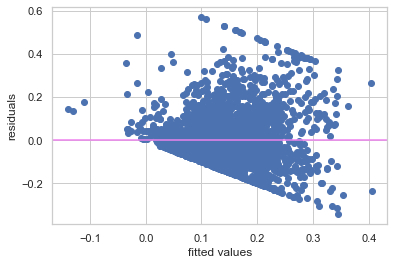

In [145]:
scatter(m1.fittedvalues, m1.resid)
axhline(y = 0, color = 'violet')
xlabel('fitted values')
ylabel('residuals')
show()

<AxesSubplot:xlabel='predictions', ylabel='residuals'>

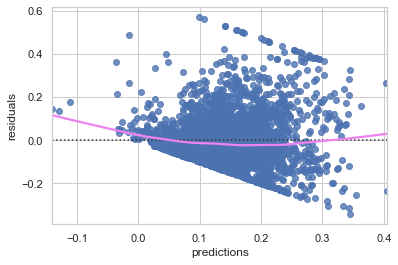

In [147]:
sns.residplot(data = ready_df, x = 'predictions', y = 'residuals', lowess = True, line_kws = dict(color = 'violet'))

In [149]:
breusch1 = sms.het_breuschpagan(m1.resid, m1.model.exog)

In [151]:
breusch_names = ['lagrange multiplier statistic', 'p-value','fvalue ', 'f_pvalue ']

In [152]:
lzip(breusch_names, breusch1)

[('lagrange multiplier statistic', 315.61849904145697),
 ('p-value', 3.154088968348471e-53),
 ('fvalue ', 15.196276508197858),
 ('f_pvalue ', 1.6329410577376127e-56)]

In [ ]:
#odrzucamy H0 o homoskedastyczności reszt